## Tanzania's Waterwell Problem 
by Jessica Guzzo 

This project aims to address the water crisis in Tanzania by predicting, when and where a water-well will be non-functional. Having non-functional water-wells is a very serious problem for the Tanzanian citizens. Water is a vital resource, and without a proper source, death can occur. This project should help the Tanzanian government, by giving them advance notice of where malfunctioning water-wells are, and allowing the government to allocate the necessary resources to mitigate the crisis. 

Water scarcity is a significant threat to human life in Tanzania. There are many water-wells in the country that try to address the issue of water starvation. However, the data indicates that many are non-functional. This project uses real world data provide by Tariff and the Tanzanian Ministry of water [Tanzanian Water](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) , to help predict non-functional water-wells.


In [1]:
#Importing libraries needed for project
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import sys

import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [2]:
#Loading the two dataframes that will be used

# Load the CSV files into pandas DataFrames
trainingsetlabels = pd.read_csv('/Users/jguzzo522/Desktop/twaterwell/trainingsetlabels.csv')
trainingsetvalues = pd.read_csv('/Users/jguzzo522/Desktop/twaterwell/trainingsetvalues.csv')

# Display the loaded datasets

print("\nTraining Set Labels:")
print(trainingsetlabels.head())
print("\nTraining Set Values:")
print(trainingsetvalues.head())



Training Set Labels:
      id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

Training Set Values:
      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.

In [3]:
# Check the number of unique IDs in each dataset
training_labels_ids = set(trainingsetlabels['id'])
training_values_ids = set(trainingsetvalues['id'])


print("Number of unique IDs in Training Set Labels:", len(training_labels_ids))
print("Number of unique IDs in Training Set Values:", len(training_values_ids))


Number of unique IDs in Training Set Labels: 59400
Number of unique IDs in Training Set Values: 59400


## Merging Training Set Values 

In order to analyze the data, a single dataset was created by merging 'training_labels_ids' and 'training_values_ids'. Merging the data, allows for a simplified process and allows for a single model to predict the functionality of water-wells. We can do this by viewing the impact of different features, and seeing how they impact the 'status_group' (water functionality). This will allow the government of Tanzania, to make faster repairs to water-wells in need.


In [4]:
import pandas as pd

# Load the CSV files into pandas DataFrames
training_set_labels = pd.read_csv('/Users/jguzzo522/Desktop/twaterwell/trainingsetlabels.csv')
training_set_values = pd.read_csv('/Users/jguzzo522/Desktop/twaterwell/trainingsetvalues.csv')

# Merge the datasets on the 'id' column
merged_data = pd.merge(training_set_values, training_set_labels, on='id', how='inner')

# Display the merged dataset
print(merged_data)


          id  amount_tsh date_recorded           funder  gps_height  \
0      69572      6000.0    2011-03-14            Roman        1390   
1       8776         0.0    2013-03-06          Grumeti        1399   
2      34310        25.0    2013-02-25     Lottery Club         686   
3      67743         0.0    2013-01-28           Unicef         263   
4      19728         0.0    2011-07-13      Action In A           0   
...      ...         ...           ...              ...         ...   
59395  60739        10.0    2013-05-03  Germany Republi        1210   
59396  27263      4700.0    2011-05-07      Cefa-njombe        1212   
59397  37057         0.0    2011-04-11              NaN           0   
59398  31282         0.0    2011-03-08            Malec           0   
59399  26348         0.0    2011-03-23       World Bank         191   

          installer  longitude   latitude              wpt_name  num_private  \
0             Roman  34.938093  -9.856322                  none    

In [5]:

# Display the first few rows of the merged dataset
merged_data.head()



,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Exploring the data


In [6]:
# Get the number of unique values for each column in the merged dataset
unique_values_counts = merged_data.nunique()

# Display the number of unique values for each column
print(unique_values_counts)


id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

| Column                | Description                                                   |
|-----------------------|---------------------------------------------------------------|
| id                    | Unique identifier for each water point                        |
| amount_tsh            | Total static head (amount of water available at water point)  |
| date_recorded         | Date the information was entered into the database            |
| funder                | Organization that funded the well                             |
| gps_height            | Elevation of the water point                                  |
| installer             | Organization that installed the well                          |
| longitude             | Geographic longitude of the water point                       |
| latitude              | Geographic latitude of the water point                        |
| wpt_name              | Name of the water point                                       |
| num_private           | Private individuals or entities associated with the well      |
| basin                 | Geographic water basin                                        |
| subvillage            | Subvillage where the water point is located                   |
| region                | Geographic region                                             |
| region_code           | Coded form of the geographic region                           |
| district_code         | Coded form of the geographic district                         |
| lga                   | Local Government Area                                         |
| ward                  | Geographic ward                                               |
| population            | Estimated population using the water point                    |
| public_meeting        | If there was a public meeting about the water point           |
| recorded_by           | Entity that entered the data into the database                |
| scheme_management     | Organization managing the water scheme                        |
| scheme_name           | Name of the water scheme                                      |
| permit                | If the water point is permitted                               |
| construction_year     | Year the water point was constructed                          |
| extraction_type       | The kind of extraction the water point uses                   |
| extraction_type_group | Group classification of the extraction type                   |
| extraction_type_class | Class classification of the extraction type                   |
| management            | How the water point is managed                                |
| management_group      | Group classification of management                            |
| payment               | The payment structure for the water point                     |
| payment_type          | Type of payment                                               |
| water_quality         | Quality of the water                                          |
| quality_group         | Group classification of water quality                         |
| quantity              | The quantity of water available                               |
| quantity_group        | Group classification of water quantity                        |
| source                | The source of the water                                       |
| source_type           | Type of source                                                |
| source_class          | Class of water source                                         |
| waterpoint_type       | The kind of water point                                       |
| waterpoint_type_group | Group classification of the water point type                  |
| status_group          | The functionality status of the water point                   |



## Converting the Dependent Variable 'status_group' from Trinary to Binary

The values of 'status_group', were adjusted from a Trinary value of 'functional', 'function_needs_repair', and 'non-functional', to a binary classification of 'functional' , and 'non-functional'. The group that was labeled as repair, was added to the 'functional' category. 



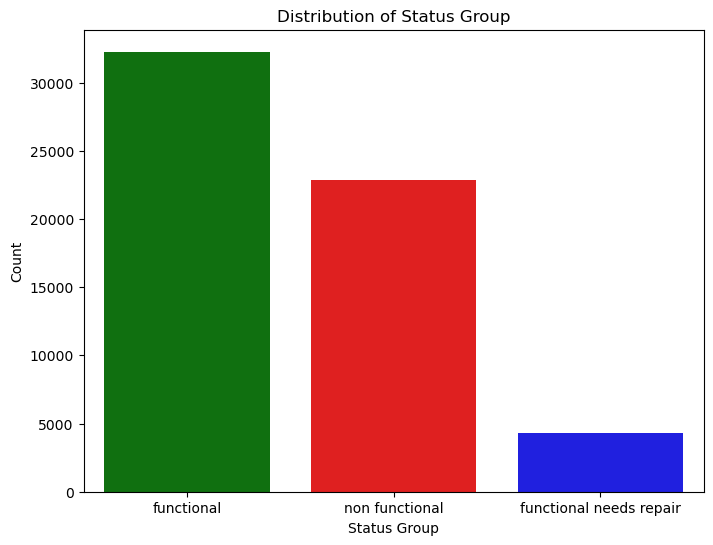

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette for each category
color_palette = {'functional': 'green', 'functional needs repair': 'blue', 'non functional': 'red'}

# Set figure size
plt.figure(figsize=(8, 6))

# Plot the counts of each category with custom colors
sns.countplot(data=merged_data, x='status_group', palette=color_palette)

# Add labels and title
plt.title('Distribution of Status Group')
plt.xlabel('Status Group')
plt.ylabel('Count')

# Show plot
plt.show()


In [8]:
# Combine 'functional' and 'functional needs repair' as positive class
merged_data['status_group_binary'] = np.where(
    merged_data['status_group'].isin(['functional', 'functional needs repair']), 1, 0
)

# Drop the original 'status_group' column
merged_data.drop(columns=['status_group'], inplace=True)

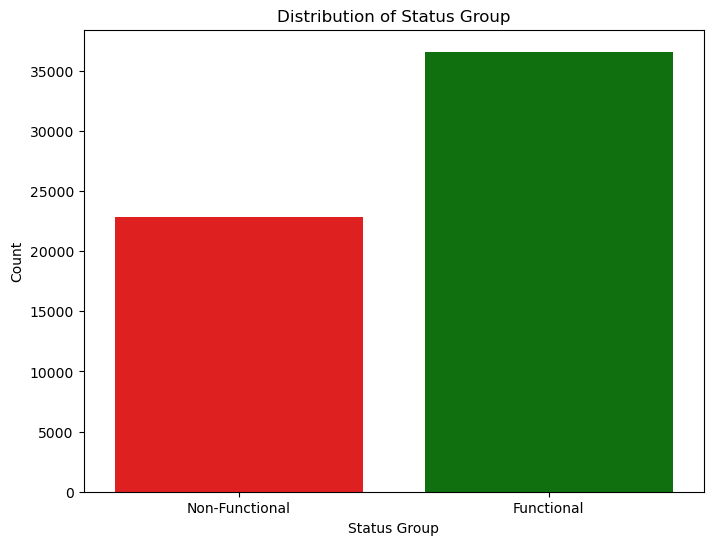

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(8, 6))

# Define color palette
color_palette = {1: 'green', 0: 'red'}

# Plot the counts of each category with custom colors
sns.countplot(data=merged_data, x='status_group_binary', palette=color_palette)

# Set the x-axis tick labels
plt.xticks(ticks=[1, 0], labels=['Functional', 'Non-Functional'])

# Add labels and title
plt.title('Distribution of Status Group')
plt.xlabel('Status Group')
plt.ylabel('Count')

# Show plot
plt.show()


## Removal of "columns

 #### Funder 
The column "funder" contains 1897 values. Attempting to analyze how 1897 different values would be very time-consuming and might not provide significant insights due to the sheer volume of categories. In order to preserve time, we decided to remove this column. 



In [10]:
# Count the number of unique values
num_unique_values = merged_data['funder'].nunique()

# Display the number of unique values
print("Number of unique values:", num_unique_values)

# Display the unique values
unique_values = merged_data['funder'].unique()
print("Unique values:")
print(unique_values)


Number of unique values: 1897
Unique values:
['Roman' 'Grumeti' 'Lottery Club' ... 'Dina' 'Brown' 'Samlo']


In [11]:
# Drop the "funder" column
merged_data.drop(columns=['funder'], inplace=True)


#### 'Subvillage'

Similarly to the 'funder' column, the 'subvillage' column had a tremendous amount of unique values (19,287). While knowing were the water-wells are non-functional is important, there were other columns in the dataset that could provide the geographic information needed. The 'subvillage' column was removed to improve the models predictive ability. 


In [12]:
# Drop the "subvillage" column
merged_data.drop(columns=['subvillage'], inplace=True)


#### 'Wpt_name'

Another column with a large amount of unique vales was 'Wpt_name' (37,400). There are too many unique values to provide predictive value. This column was removed. 

In [13]:
# Drop the "wpt_name" column
merged_data.drop(columns=['wpt_name'], inplace=True)


#### 'scheme_management' and 'scheme_name'
Investigation into columns  'scheme_management' and 'scheme_name', indicated that these were duplicate values. Both of these columns represented the group responsible for operating the water-well. However, 'scheme_management had only 12 unique values, where 'scheme_name' had 2696 values. To make the data more managble, 'scheme_name' was removed. 


In [14]:
# Drop the "scheme_name" column
merged_data.drop(columns=['scheme_name'], inplace=True)

#### 'Installer

Similar to other columns, 'installer' had a vast number of unique values (2,146). For this reason to simplify the dataset this column was removed from analysis.


In [15]:
# Check the number of unique values in the 'installer' column
num_unique_installers = len(merged_data['installer'].unique())
print("Number of unique installers:", num_unique_installers)

# Display some of the unique values in the 'installer' column
unique_installers = merged_data['installer'].unique()
print("Unique installers:", unique_installers[:10])  # Displaying the first 10 unique values


Number of unique installers: 2146
Unique installers: ['Roman' 'GRUMETI' 'World vision' 'UNICEF' 'Artisan' 'DWE' 'DWSP'
 'Water Aid' 'Private' 'DANIDA']


In [16]:
# Drop the "installer" column
merged_data.drop(columns=['installer'], inplace=True)


#### 'Mangement' and 'management_group'

The columns management' and 'management_group' are duplicate columns. One of these columns needed to be removed. The 'management' column had 12 unique values, while the 'managment_group' only had 5 unique values. It was decided to remove the 'management_group' column because the 'management' column had a manageable amount of values and offered more unique values, which could help the Tanzanian government pinpoint the problem. 

In [17]:
unique_management_values = merged_data['management'].unique()
unique_management_group_values = merged_data['management_group'].unique()

print("Unique values in 'management':")
print(unique_management_values)

print("\nUnique values in 'management_group':")
print(unique_management_group_values)


Unique values in 'management':
['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']

Unique values in 'management_group':
['user-group' 'other' 'commercial' 'parastatal' 'unknown']


In [18]:
# Drop the "managment" column
merged_data.drop(columns=['management'], inplace=True)

#### 'Waterpoint_type_group' 

While reviewing the 'waterpoint_type' and 'waterpoint_type_group' columns, it's was clear that these were duplicate columns that represented categories of water points . However, 'waterpoint_type' provides more detailed distinctions with seven  values, while 'waterpoint_type_group' only has 6 categories. By keeping the column with slightly more categories, it is hopeful that we can provide the Tanzanian government with more insights. For this reason 'waterpoint_type_group' was removed.


In [19]:
# Unique values in 'waterpoint_type'
print("Unique values in 'waterpoint_type':")
print(merged_data['waterpoint_type'].unique())

# Unique values in 'waterpoint_type_group'
print("\nUnique values in 'waterpoint_type_group':")
print(merged_data['waterpoint_type_group'].unique())


Unique values in 'waterpoint_type':
['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']

Unique values in 'waterpoint_type_group':
['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']


In [20]:
# Drop the "waterpoint_type_group" column
merged_data.drop(columns=['waterpoint_type_group'], inplace=True)

#### 'Quantity_group'
Upon examination, it was clear these two columns were identical. Therefore it was appropriate to remove one column and so 'quantity_group' was dropped.

In [21]:
print("Unique values in 'quantity':")
print(merged_data['quantity'].unique())

print("\nUnique values in 'quantity_group':")
print(merged_data['quantity_group'].unique())
print("Number of NaN values in 'quantity':", merged_data['quantity'].isna().sum())
print("Number of NaN values in 'quantity_group':", merged_data['quantity_group'].isna().sum())



Unique values in 'quantity':
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']

Unique values in 'quantity_group':
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
Number of NaN values in 'quantity': 0
Number of NaN values in 'quantity_group': 0


In [22]:
# Drop the "quantity_group" column
merged_data.drop(columns=['quantity_group'], inplace=True)

#### 'Quality_group' 

The values in the 'water_quality and 'quality_group' columns, are duplicate columns. They represent the quality of water. However, 'water_quality' is more detailed  with eight unique values, while 'quality_group' only has six categories. This column seems significant in predicting water-well functionality and for this reason, it was deemed reasonable to keep the column with more detailed values. The column 'quality_group' was removed from the dataset. 


In [23]:
print("Unique values in 'water_quality':")
print(merged_data['water_quality'].unique())

print("\nUnique values in 'quality_group':")
print(merged_data['quality_group'].unique())
print("Number of NaN values in 'water_quality':", merged_data['water_quality'].isna().sum())
print("Number of NaN values in 'quality_group':", merged_data['quality_group'].isna().sum())


Unique values in 'water_quality':
['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']

Unique values in 'quality_group':
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']
Number of NaN values in 'water_quality': 0
Number of NaN values in 'quality_group': 0


In [24]:
# Count occurrences of 'unknown' in 'water_quality'
unknown_water_quality_count = merged_data['water_quality'].value_counts().get('unknown', 0)

# Count occurrences of 'unknown' in 'quality_group'
unknown_quality_group_count = merged_data['quality_group'].value_counts().get('unknown', 0)

print("Number of 'unknown' values in 'water_quality':", unknown_water_quality_count)
print("Number of 'unknown' values in 'quality_group':", unknown_quality_group_count)


Number of 'unknown' values in 'water_quality': 1876
Number of 'unknown' values in 'quality_group': 1876


In [25]:
# Drop the "quantity_group" column
merged_data.drop(columns=['quality_group'], inplace=True)

#### 'recorded_by'

This column contains only one value. This means there is no possible distinctions between groups, and therefore this column was removed.

In [26]:
# Drop the 'recorded_by' column
merged_data.drop(columns=['recorded_by'], inplace=True)


#### 'payment_type'
Upon examination, it was clear these two columns were identical. Therefore it was appropriate to remove one column and so 'payment_type' was dropped.

In [27]:
print("Unique values in 'payment':")
print(merged_data['payment'].unique())

print("\nUnique values in 'payment_type':")
print(merged_data['payment_type'].unique())
print("Number of NaN values in 'payment':", merged_data['payment'].isna().sum())
print("Number of NaN values in 'payment_type':", merged_data['payment_type'].isna().sum())


Unique values in 'payment':
['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']

Unique values in 'payment_type':
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']
Number of NaN values in 'payment': 0
Number of NaN values in 'payment_type': 0


In [28]:
# Drop the "payment_type" column
merged_data.drop(columns=['payment_type'], inplace=True)

#### 'Source_type' and 'Source_class'

These columns both represent the source of water. One of these columns was removed becasue it was deemed redundant. 'Source_type' was retained because this column had more unique values(7) than did 'source_class' (3). 

Considering the potential significance of the distinctions between different sources of water, it may be beneficial to retain the column with more information ('source') and drop the other two column with fewer unique values ('source_type' and 'source_class). 

In [29]:
# Unique values for source_type
print("Unique values in 'source_type':")
print(merged_data['source_type'].unique())

# Unique values for source
print("Unique values in 'source':")
print(merged_data['source'].unique())


# Unique values for source_class
print("Unique values in 'source_class':")
print(merged_data['source_class'].unique())

Unique values in 'source_type':
['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
Unique values in 'source':
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
Unique values in 'source_class':
['groundwater' 'surface' 'unknown']


In [30]:
# Drop the 'source_type' column
merged_data.drop(columns=['source_type'], inplace=True)
# Drop the 'source_class' column
merged_data.drop(columns=['source_class'], inplace=True)

#### 'Extraction_type_group' and 'Extraction_type_class'

After reviewing it was evident that the 'extraction_type' column provides a more detailed categorization with a wider range of variables compared to 'extraction_type_group' and 'extraction_type_class'. While 'extraction_type' contains 18 unique values, 'extraction_type_group' and 'extraction_type_class' have fewer categories, potentially resulting in less detailed information. For this reason we retained 'extraction_type'.


In [31]:
# Unique values in 'extraction_type'
print("Unique values in 'extraction_type':")
print(merged_data['extraction_type'].unique())

# Unique values in 'extraction_type_group'
print("\nUnique values in 'extraction_type_group':")
print(merged_data['extraction_type_group'].unique())

# Unique values in 'extraction_type_class'
print("\nUnique values in 'extraction_type_class':")
print(merged_data['extraction_type_class'].unique())


Unique values in 'extraction_type':
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']

Unique values in 'extraction_type_group':
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']

Unique values in 'extraction_type_class':
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


In [32]:
# Drop 'extraction_type_group' and 'extraction_type_class'
merged_data.drop(columns=['extraction_type_group', 'extraction_type_class'], inplace=True)


In [33]:
print("Unique values in 'region_code':")
print(merged_data['region_code'].unique())

print("\nUnique values in 'district_code':")
print(merged_data['district_code'].unique())


Unique values in 'region_code':
[11 20 21 90 18  4 17 14 60 10  3 15 19 16 80  1  6  2 12 13  5  7 99 24
  9  8 40]

Unique values in 'district_code':
[ 5  2  4 63  1  8  3  6 43  7 23 33 53 62 60 30 13  0 80 67]


In [34]:
# Display the first few rows of the merged dataset
merged_data.head()


,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,basin,region,region_code,...,permit,construction_year,extraction_type,management_group,payment,water_quality,quantity,source,waterpoint_type,status_group_binary
0,69572,6000.0,2011-03-14,1390,34.938093,-9.856322,0,Lake Nyasa,Iringa,11,...,False,1999,gravity,user-group,pay annually,soft,enough,spring,communal standpipe,1
1,8776,0.0,2013-03-06,1399,34.698766,-2.147466,0,Lake Victoria,Mara,20,...,True,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,1
2,34310,25.0,2013-02-25,686,37.460664,-3.821329,0,Pangani,Manyara,21,...,True,2009,gravity,user-group,pay per bucket,soft,enough,dam,communal standpipe multiple,1
3,67743,0.0,2013-01-28,263,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,...,True,1986,submersible,user-group,never pay,soft,dry,machine dbh,communal standpipe multiple,0
4,19728,0.0,2011-07-13,0,31.130847,-1.825359,0,Lake Victoria,Kagera,18,...,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,1


#### 'Ward' and 'lga'

These columns had alot of individual values, and distric code had less. The geographical information was obtainied by the region instead. 

In [35]:
# Drop 'ward' and 'lga'
merged_data.drop(columns=['ward', 'lga'], inplace=True)


In [36]:
# Display the first few rows of the merged dataset
merged_data.head()




,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,basin,region,region_code,...,permit,construction_year,extraction_type,management_group,payment,water_quality,quantity,source,waterpoint_type,status_group_binary
0,69572,6000.0,2011-03-14,1390,34.938093,-9.856322,0,Lake Nyasa,Iringa,11,...,False,1999,gravity,user-group,pay annually,soft,enough,spring,communal standpipe,1
1,8776,0.0,2013-03-06,1399,34.698766,-2.147466,0,Lake Victoria,Mara,20,...,True,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,1
2,34310,25.0,2013-02-25,686,37.460664,-3.821329,0,Pangani,Manyara,21,...,True,2009,gravity,user-group,pay per bucket,soft,enough,dam,communal standpipe multiple,1
3,67743,0.0,2013-01-28,263,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,...,True,1986,submersible,user-group,never pay,soft,dry,machine dbh,communal standpipe multiple,0
4,19728,0.0,2011-07-13,0,31.130847,-1.825359,0,Lake Victoria,Kagera,18,...,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,1


In [37]:
# Get the list of columns for merged_data
merged_data_columns = merged_data.columns.tolist()



# Display the columns for both datasets
print("Columns in merged_data:", merged_data_columns)



Columns in merged_data: ['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'num_private', 'basin', 'region', 'region_code', 'district_code', 'population', 'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'management_group', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'status_group_binary']


## Reviewing Datasets for Missing and Duplicate Data

Reviewing the datasets for missing or duplicate data is important to ensure data reliability. 

In [38]:
# Count missing values in merged_data
missing_merged_data = merged_data.isnull().sum()
print("Missing values in merged_data:")
print(missing_merged_data)
# Check for duplicates in merged_data
duplicate_rows = merged_data.duplicated()
print("Number of duplicate rows in merged_data:", duplicate_rows.sum())


Missing values in merged_data:
id                        0
amount_tsh                0
date_recorded             0
gps_height                0
longitude                 0
latitude                  0
num_private               0
basin                     0
region                    0
region_code               0
district_code             0
population                0
public_meeting         3334
scheme_management      3877
permit                 3056
construction_year         0
extraction_type           0
management_group          0
payment                   0
water_quality             0
quantity                  0
source                    0
waterpoint_type           0
status_group_binary       0
dtype: int64
Number of duplicate rows in merged_data: 0


## 'Construction_year'

The 'constuction_year' column seemed logically important. As many buildings, or projects created many decades ago, often need repair. However, the data have 20,709 missing values. To address this issue, KNN (K-Nearest Neighbors) imputation was employed. This is a technique used in Data Science to address missing values by considering the values of similar neighbor data points rows. Then using the value in this case 'neighbors=5', the method analysis the similarities of columns, and replaces the unknown 'construction', with a best estimated value.

After addressing missing values in the construction_year column with KNN imputation, we decided to create sub-catagories of decades. These sub-catagories were created to make the data more readable. It also allows for easier interpretation, and allocation of resources. For instance the data indicate older water-wells are significantly more likley to be non-functional. The Tanzanian government could look ad this catagory amd easily identify potential problems. 


In [39]:
construction_years = merged_data['construction_year'].value_counts().sort_index()
print("Construction Years:")
print(construction_years)


Construction Years:
0       20709
1960      102
1961       21
1962       30
1963       85
1964       40
1965       19
1966       17
1967       88
1968       77
1969       59
1970      411
1971      145
1972      708
1973      184
1974      676
1975      437
1976      414
1977      202
1978     1037
1979      192
1980      811
1981      238
1982      744
1983      488
1984      779
1985      945
1986      434
1987      302
1988      521
1989      316
1990      954
1991      324
1992      640
1993      608
1994      738
1995     1014
1996      811
1997      644
1998      966
1999      979
2000     2091
2001      540
2002     1075
2003     1286
2004     1123
2005     1011
2006     1471
2007     1587
2008     2613
2009     2533
2010     2645
2011     1256
2012     1084
2013      176
Name: construction_year, dtype: int64


In [40]:
from sklearn.impute import KNNImputer

# Step 1: Perform KNN imputation on the construction_year column
imputer = KNNImputer(n_neighbors=5)  

# Replace missing values with NaN
merged_data.loc[merged_data['construction_year'] == 0, 'construction_year'] = np.nan

# Apply KNN imputation
merged_data_imputed = imputer.fit_transform(merged_data[['construction_year']])

# Replace the original construction year column with the imputed values
merged_data['construction_year'] = merged_data_imputed

# Step 2: Categorize construction years into decades
# Define the ranges for each decade
decade_ranges = {
    '1960s': range(1960, 1970),
    '1970s': range(1970, 1980),
    '1980s': range(1980, 1990),
    '1990s': range(1990, 2000),
    '2000s': range(2000, 2010),
    '2010s': range(2010, 2020)
}

# Function to categorize construction years into decades
def categorize_decade(year):
    for decade, year_range in decade_ranges.items():
        if year in year_range:
            return decade
    return 'Unknown'

# Create a new column for the decade
merged_data['decade_construction'] = merged_data['construction_year'].apply(categorize_decade)

# Display the unique values in the new decade column
unique_decades = merged_data['decade_construction'].unique()
print(unique_decades)


['1990s' '2010s' '2000s' '1980s' 'Unknown' '1970s' '1960s']


In [41]:
# Round the construction years to the nearest whole number
merged_data['construction_year'] = round(merged_data['construction_year'])

# Recategorize construction years into decades
merged_data['decade_construction'] = merged_data['construction_year'].apply(categorize_decade)

# Display the count of construction years falling into each decade
print("Count of Construction Years by Decade:")
for decade in unique_decades:
    count = merged_data[merged_data['decade_construction'] == decade].shape[0]
    print(f"{decade}: {count}")

Count of Construction Years by Decade:
1990s: 28387
2010s: 5161
2000s: 15330
1980s: 5578
Unknown: 0
1970s: 4406
1960s: 538


## Visualization of Functional vs Non-Functional Water Wells Based on Decade of Construction

In this chart a stacked bar graph was created to show the percentage of functional versus non-function water-wells in each decade. The blue part of the bar shows the percentage of functional water wells, and the red part shows the non-functional water wells. This chart indicates that older water-wells created in the 1960's-1980's all have more non-functional water-wells than functional. Newer wells performed the best with water-wells in the 2010's having a functional rate around 80%. 

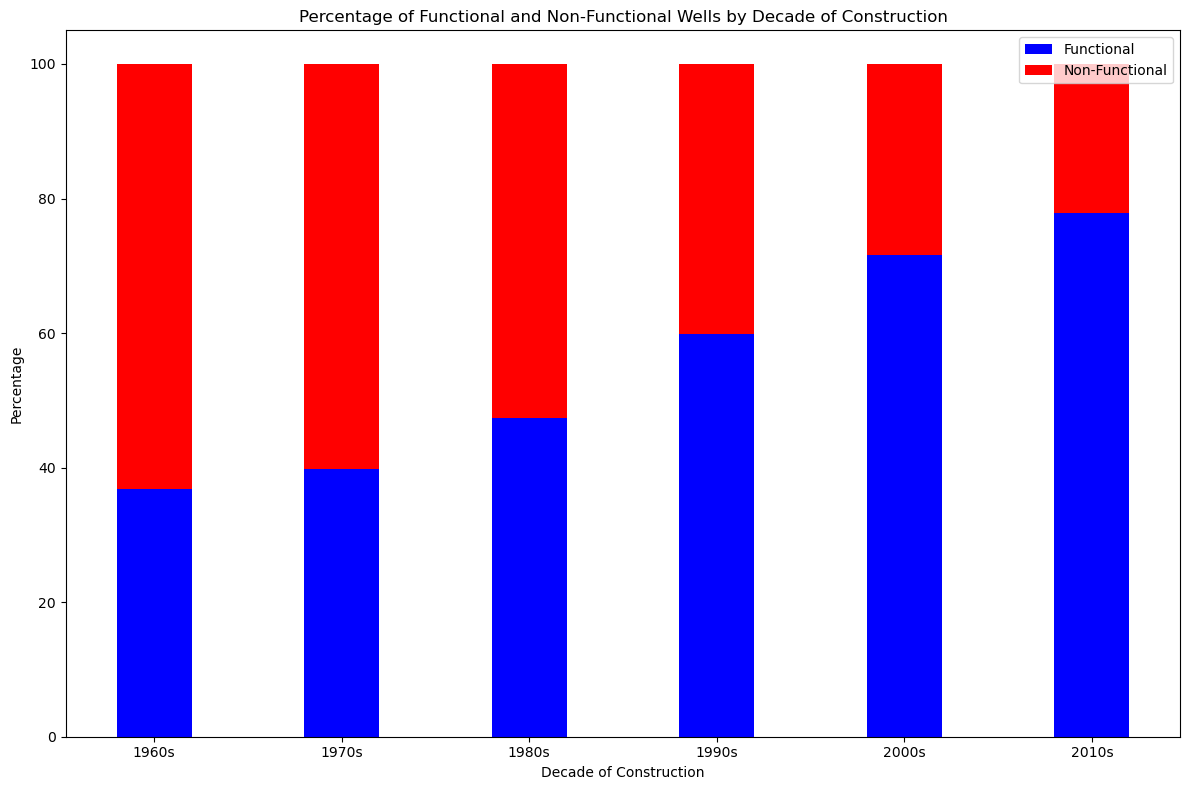

In [42]:
import matplotlib.pyplot as plt

# Calculate the total count of wells for each decade category
decade_total_counts = merged_data['decade_construction'].value_counts()

# Group the dataset by decade category and status group, then count the number of wells in each group
decade_status_counts = merged_data.groupby(['decade_construction', 'status_group_binary']).size().unstack(fill_value=0)

# Calculate the percentage of functional and non-functional wells within each decade category
decade_percentages = decade_status_counts.div(decade_total_counts, axis=0) * 100

# Extract decades and status groups
decades = decade_percentages.index
status_groups = decade_percentages.columns

# Define bar width
bar_width = 0.4
index = range(len(decades))

# Plotting
plt.figure(figsize=(12, 8))

# Plot stacked bars for functional and non-functional wells for each decade category
plt.bar(index, decade_percentages[1], bar_width, color='b', label='Functional')
plt.bar(index, decade_percentages[0], bar_width, color='r', bottom=decade_percentages[1], label='Non-Functional')

# Add labels, title, legend, and adjust layout
plt.xlabel('Decade of Construction')
plt.ylabel('Percentage')
plt.title('Percentage of Functional and Non-Functional Wells by Decade of Construction')
plt.xticks(index, decades)
plt.legend()
plt.tight_layout()
plt.show()



In [43]:
# Total number of values in each column
total_values = len(merged_data)
column_value_counts = merged_data.count()

# Percentage of missing values for public_meeting, scheme_management, and permit
missing_percentages = {
    'public_meeting': (total_values - column_value_counts['public_meeting']) / total_values * 100,
    'scheme_management': (total_values - column_value_counts['scheme_management']) / total_values * 100,
    'permit': (total_values - column_value_counts['permit']) / total_values * 100
}

print("Total number of values in each column:")
print(column_value_counts)
print("\nPercentage of missing values:")
print(missing_percentages)


Total number of values in each column:
id                     59400
amount_tsh             59400
date_recorded          59400
gps_height             59400
longitude              59400
latitude               59400
num_private            59400
basin                  59400
region                 59400
region_code            59400
district_code          59400
population             59400
public_meeting         56066
scheme_management      55523
permit                 56344
construction_year      59400
extraction_type        59400
management_group       59400
payment                59400
water_quality          59400
quantity               59400
source                 59400
waterpoint_type        59400
status_group_binary    59400
decade_construction    59400
dtype: int64

Percentage of missing values:
{'public_meeting': 5.612794612794613, 'scheme_management': 6.526936026936027, 'permit': 5.144781144781145}


## Data Cleaning

After further review, I decided to drop rows with missing values in the columns `public_meeting`, `scheme_management`, and `permit`. Although these missing values constituted a small percentage of the remaining data, it was necessary to ensure the reliability of the dataset for analysis and modeling purposes.

The decision to drop rows with missing values was made after careful consideration of the potential impact on the integrity of the data and the significance of the missing values relative to the size of the dataset.

Additionaly, 'construction_year' was dropped because this column was transformed into decade_constuction'.


In [44]:
# Drop rows with missing values in specified columns
merged_data.drop(['public_meeting', 'scheme_management', 'construction_year', 'permit'], axis=1, inplace=True)



There were no apparent outliers or missing data points in the 'date_recorded' column. However, a detailed review revealed a limited variety of years represented in the data, diminishing its utility for our analysis. Consequently, this column was excluded from the dataset to streamline our focus on more impactful variables. Future analysis may revisit this decision, especially to explore the potential effects of seasonal variations on our findings. Incorporating 'date_recorded' in a refined model could offer insights into temporal factors influencing the dataset, warranting further investigation.

In [45]:
# Drop 'date_recorded

merged_data.drop(columns=['date_recorded'], inplace=True)


## Exploring 'gps_height'
In our dataset's exploration, we initially analyzed the frequency distribution of GPS heights using a histogram, uncovering a wide range of elevation values. Given the broad spectrum of GPS heights, we introduced a categorization scheme to simplify the data and aid in our analysis. The GPS heights were divided into the following subcategories based on their elevation in meters:

0 and below: Represents water points at sea level or below.
0-500: Water points situated at elevations up to 500 meters.
500-1000: Elevations ranging from 501 to 1000 meters.
1000-1500: Elevations from 1001 to 1500 meters.
1500-2000: Elevations between 1501 and 2000 meters.
2000+: Water points located at elevations above 2000 meters.
This categorization enables a more manageable analysis, facilitating an examination of how GPS height impacts water point functionality and accessibility. By segmenting the water wells into these distinct elevation bands, we can more precisely assess the relationship between a water point's location's elevation and its operational status, potentially uncovering insights into environmental or infrastructural factors that influence water availability and quality.

In [46]:
 
gps_height_merged = merged_data['gps_height'].value_counts().sort_index()
print("Gps Height Merged:")
print(gps_height_merged)

Gps Height Merged:
-90      1
-63      2
-59      1
-57      1
-55      1
        ..
 2623    1
 2626    2
 2627    1
 2628    1
 2770    1
Name: gps_height, Length: 2428, dtype: int64


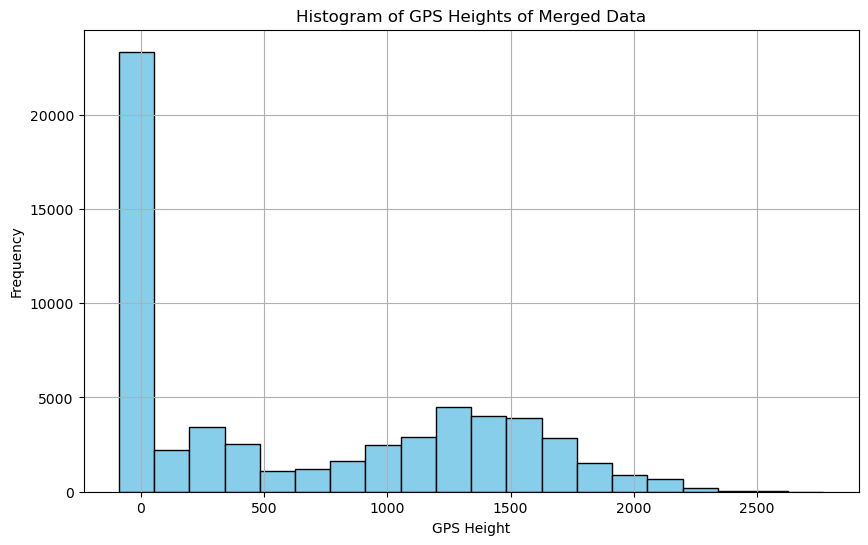

In [47]:
import matplotlib.pyplot as plt

# Plot histogram of GPS heights
plt.figure(figsize=(10, 6))
plt.hist(merged_data['gps_height'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('GPS Height')
plt.ylabel('Frequency')
plt.title('Histogram of GPS Heights of Merged Data')
plt.grid(True)
plt.show()

In [48]:
# Define function to categorize GPS heights into subcategories
def categorize_gps_heightm(height):
    if height <= 0:
        return '0 and below'
    elif height <= 500:
        return '0-500'
    elif height <= 1000:
        return '500-1000'
    elif height <= 1500:
        return '1000-1500'
    elif height <= 2000:
        return '1500-2000'
    else:
        return '2000+'


# Correctly apply the categorize_gps_heightm function to create the 'gps_height_categorym' column
merged_data['gps_height_categorym'] = merged_data['gps_height'].apply(categorize_gps_heightm)






## Percentage of Functional and Non-Functional Wells by GPS Height Category
This chart visualizes the relationship between the functionality of water wells and their GPS height, categorizing wells into functional and non-functional based on their elevation. It employs a stacked bar graph to display the proportions of functional versus non-functional wells across various GPS height categories, illustrating how elevation potentially influences well performance. The visualization aims to provide insights into trends and patterns that might affect water resource management strategies.

This chart visualizes the relationship between the functionality of water wells and their GPS height, categorizing wells into functional and non-functional based on their elevation. It employs a stacked bar graph to display the proportions of functional versus non-functional wells across various GPS height categories, illustrating how elevation potentially influences well performance. The visualization reveals a general trend where increased GPS height correlates with higher functionality rates among wells. Notably, wells at the lowest elevation (0 meters and below) exhibit a slightly higher functionality rate compared to those in the 0-500 meter range. This pattern suggests that while elevation is a significant factor in well functionality, other environmental or management factors may also play crucial roles. The insights from this analysis could inform water resource management strategies, emphasizing the need to consider a variety of factors in maintaining and improving well functionality.

In [49]:
# Group the data by GPS height category and status group, then count the number of wells in each group
gps_height_status_counts = merged_data.groupby(['gps_height_categorym', 'status_group_binary']).size().unstack(fill_value=0)

# Calculate the total counts for each GPS height category
total_counts_by_category = gps_height_status_counts.sum(axis=1)

# Calculate the percentage of functional and non-functional wells in each category
percentage_gps_height_status = (gps_height_status_counts.div(total_counts_by_category, axis=0) * 100)


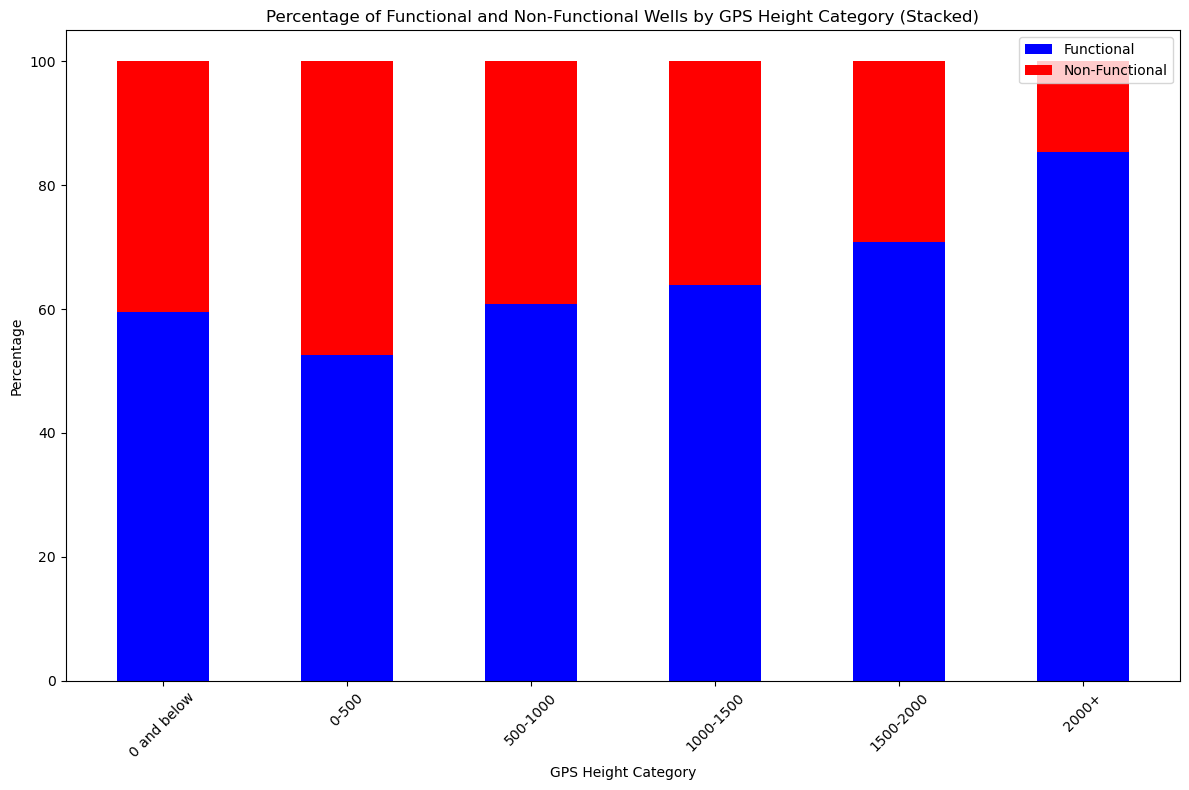

In [50]:
# Define the desired order for GPS height categories
categories_order = ['0 and below', '0-500', '500-1000', '1000-1500', '1500-2000', '2000+']

# Reindex your DataFrame to reflect this order for the calculation
percentage_gps_height_status_ordered = percentage_gps_height_status.reindex(categories_order)

# Extract the ordered categories for plotting
categories_ordered = percentage_gps_height_status_ordered.index

# Plot setup
bar_width = 0.5  # Use a full bar width for stacking
index = np.arange(len(categories_ordered))

plt.figure(figsize=(12, 8))

# Plot stacked bars for functional and non-functional wells
# Note: For stacked bars, the 'bottom' parameter determines where the top of the previous bar ends
plt.bar(index, percentage_gps_height_status_ordered[1], bar_width, color='b', label='Functional')
plt.bar(index, percentage_gps_height_status_ordered[0], bar_width, bottom=percentage_gps_height_status_ordered[1], color='r', label='Non-Functional')

# Add labels, title, legend, and adjust layout
plt.xlabel('GPS Height Category')
plt.ylabel('Percentage')
plt.title('Percentage of Functional and Non-Functional Wells by GPS Height Category (Stacked)')
plt.xticks(index, categories_ordered, rotation=45)  # Labeling x-axis ticks with categories in order
plt.legend()
plt.tight_layout()
plt.show()


In [51]:
# Check the counts of functional and non-functional wells for each status
status_counts = merged_data['status_group_binary'].value_counts()
print(status_counts)


1    36576
0    22824
Name: status_group_binary, dtype: int64


## Analysis of 'amount_tsh': Total Static Head in Water Wells
The 'amount_tsh' variable, representing the total static head or the amount of water available in the wells, was subjected to a detailed statistical analysis to understand its distribution and identify outliers. Summary statistics and percentile analysis were utilized to gauge the variability and outlier presence within this dataset.

Summary Statistics and Outlier Detection
Summary Statistics:

The dataset comprises 49,841 observations.
The mean 'amount_tsh' is approximately 352.22, with a substantial standard deviation of 2793.45, indicating wide variance.
The minimum recorded value is 0, which is plausible as many wells may not have available water. The maximum value observed is 250,000 TSH, showcasing extreme variability in water availability across wells.
75% of the data have 'amount_tsh' values at or below 30 TSH, revealing that a significant portion of wells have low to no water availability.

Summary Statistics for amount_tsh:
count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64


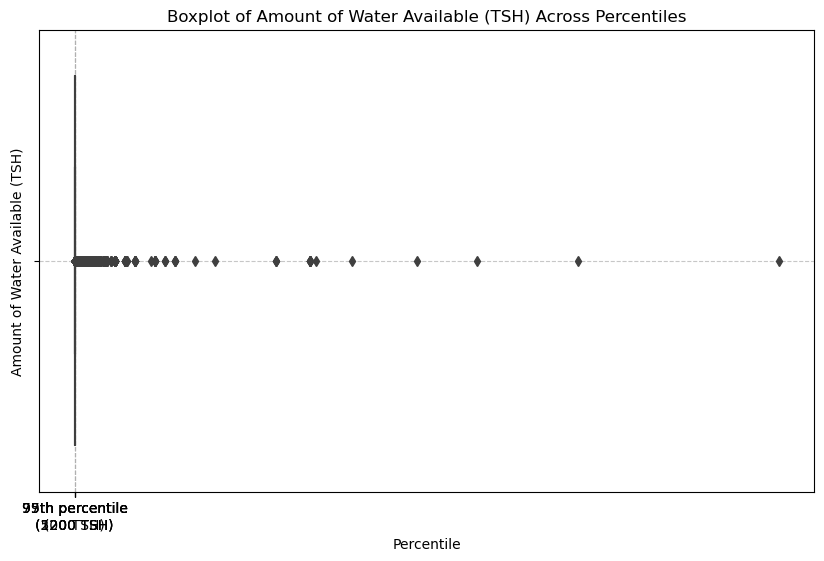

In [52]:
import matplotlib.pyplot as plt

# Summary statistics
summary_stats = merged_data['amount_tsh'].describe()
print("Summary Statistics for amount_tsh:")
print(summary_stats)

import matplotlib.pyplot as plt

import seaborn as sns

# Define the percentiles of interest
percentiles = [75, 95, 97, 99]

# Calculate the specified percentiles for amount_tsh
percentile_values = merged_data['amount_tsh'].quantile([p / 100 for p in percentiles])

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['amount_tsh'])
plt.xticks(ticks=range(len(percentiles)), labels=[f'{p}th percentile\n({int(value)} TSH)' for p, value in zip(percentiles, percentile_values)])
plt.xlabel('Percentile')
plt.ylabel('Amount of Water Available (TSH)')
plt.title('Boxplot of Amount of Water Available (TSH) Across Percentiles')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()




### Outlier Analysis:

Outliers were identified using percentile thresholds (75th, 95th, 97th, and 99th percentiles), revealing a considerable number of observations beyond these markers, indicating the presence of extreme values in the distribution.
Beyond the 75th percentile, 12,334 observations are considered outliers, underscoring the skewed nature of this variable towards lower 'amount_tsh' values.

In [53]:
# Calculate the number of outliers beyond each specified percentile
outliers_counts = [merged_data[merged_data['amount_tsh'] > merged_data['amount_tsh'].quantile(p / 100)].shape[0] for p in percentiles]

# Print the number of outliers
for p, outliers_count in zip(percentiles, outliers_counts):
    print(f'Number of outliers beyond the {p}th percentile: {outliers_count}')


Number of outliers beyond the 75th percentile: 14820
Number of outliers beyond the 95th percentile: 2723
Number of outliers beyond the 97th percentile: 1780
Number of outliers beyond the 99th percentile: 470


Given the potential for wells to have a 'amount_tsh' of 0 (indicating no water availability) and the significant variance observed in the dataset, no observations were removed. The presence of high 'amount_tsh' values, while seemingly outliers, could represent wells with substantial water availability, essential for the analysis.

This careful consideration highlights the complexity of managing and interpreting water resource data, where both extremely low and high values carry crucial information about water availability and access.

Visualization
A boxplot was generated to visually represent the distribution of 'amount_tsh' across specified percentiles, offering a clear view of the data's spread and the concentration of outliers. This visualization aids in understanding the variable's distribution at a glance, reinforcing the statistical findings.

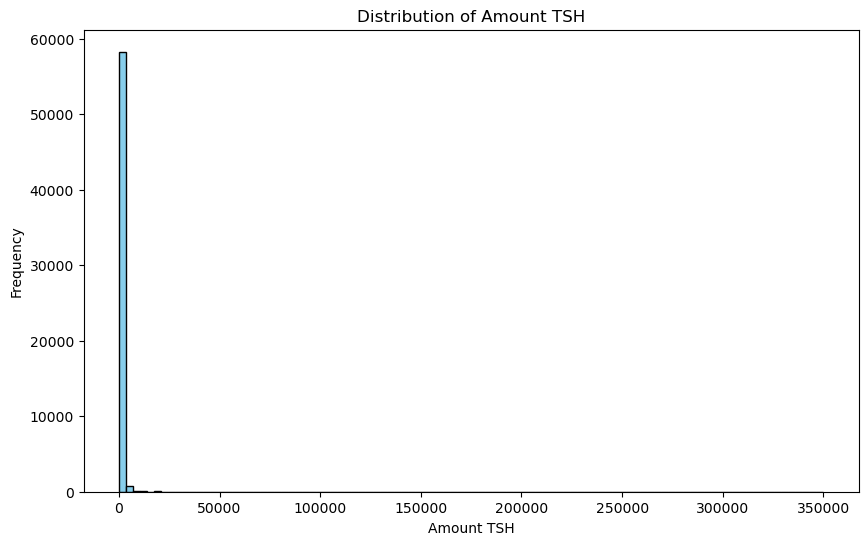

In [54]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(merged_data['amount_tsh'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Distribution of Amount TSH')
plt.xlabel('Amount TSH')
plt.ylabel('Frequency')

# Show plot
plt.show()


## Exploring 'population'
The initial data inspection revealed a significant number of instances where the population value is recorded as 0, specifically 18,088 cases. Recognizing the potential impact of such inaccuracies on our analysis, I employed a strategy to address these zero values, aiming for a more accurate representation of the population data.

In [55]:
# Check for missing values in the population column
missing_population = merged_data['population'].isnull().sum()
print("Number of missing values in population:", missing_population)

# Inspect unique values in the population column
unique_population = merged_data['population'].unique()
print("Unique population:", unique_population)




Number of missing values in population: 0
Unique population: [109 280 250 ... 845 976 788]


In [56]:
# Count the number of instances where population is 0
population_zero_count = (merged_data['population'] == 0).sum()
print("Number of instances where population is 0:", population_zero_count)


Number of instances where population is 0: 21381


To address missing values in the `population` column, I opted to utilize KNN (K-Nearest Neighbors) imputation. KNN imputation is a technique used to estimate missing values in a dataset by considering the values of nearby data points. 

In this context, KNN imputation will estimate the missing population based on the population of neighboring data points. By leveraging the similarity of neighboring observations, KNN imputation provides a reasonable approximation of the missing values.



In [57]:
#checking to see if any population still has 0

from sklearn.impute import KNNImputer

# Create a KNNImputer object
imputer = KNNImputer(n_neighbors=5)  

# Select the columns containing continuous variables
continuous_columns = ['population']  
# Replace missing values with NaN
merged_data.loc[merged_data['population'] == 0, 'population'] = np.nan

# Apply KNN imputation
merged_data_imputed = imputer.fit_transform(merged_data[continuous_columns])

# Replace the original population column with the imputed values
merged_data['population'] = merged_data_imputed

# Check the results
print(merged_data['population'].isnull().sum())  # Ensure there are no missing values remaining

0


In [58]:
# Count the number of instances where population is 0
population_zero_count = (merged_data['population'] == 0).sum()
print("Number of instances where population is 0:", population_zero_count)


Number of instances where population is 0: 0


## Water Wells in Tanzania: Spatial Analysis

By filtering out data points with longitude and latitude outside Tanzania's bounds, we eliminated outliers. Three distinct maps were generated to visualize the distribution of functional, non-functional, and both categories of water wells. Although these maps don't identify the causes behind the need for repairs, they provide valuable insights for governmental planning on where to allocate repair resources.


In [59]:
# Count the number of instances where longitude and latitude is 0
longitude_zero_count = (merged_data['longitude'] == 0).sum()
print("Number of instances where longitude is 0:", longitude_zero_count)# Count the number of instances where longitude is 0
latitude_zero_count = (merged_data['latitude'] == 0).sum()
print("Number of instances where latitude is 0:", latitude_zero_count)


Number of instances where longitude is 0: 1812
Number of instances where latitude is 0: 0


In [60]:
# Filter the dataset to get the latitude and longitude of functional and non-functional wells
functional_wells = merged_data[merged_data['status_group_binary'] == 1]
non_functional_wells = merged_data[merged_data['status_group_binary'] == 0]

# Get the counts of functional and non-functional wells
functional_count = merged_data['status_group_binary'].value_counts()[1]
non_functional_count = merged_data['status_group_binary'].value_counts()[0]

print("Number of Functional Wells:", functional_count)
print("Number of Non-Functional Wells:", non_functional_count)



Number of Functional Wells: 36576
Number of Non-Functional Wells: 22824


In [61]:
# Define the latitude and longitude ranges for Tanzania
latitude_range = (-11.7, -0.5)
longitude_range = (29.4, 40.5)

# Filter the data to include only the rows within the specified latitude and longitude ranges
merged_data = merged_data[
    (merged_data['latitude'] >= latitude_range[0]) & (merged_data['latitude'] <= latitude_range[1]) &
    (merged_data['longitude'] >= longitude_range[0]) & (merged_data['longitude'] <= longitude_range[1])
]


In [62]:


# Summary statistics for latitude and longitude after filtering
print("\nAfter filtering:")
print(merged_data[['latitude', 'longitude']].describe())



After filtering:
           latitude     longitude
count  57588.000000  57588.000000
mean      -5.885572     35.149669
std        2.809876      2.607428
min      -11.649440     29.607122
25%       -8.643841     33.285100
50%       -5.172704     35.005943
75%       -3.372824     37.233712
max       -0.998464     40.345193


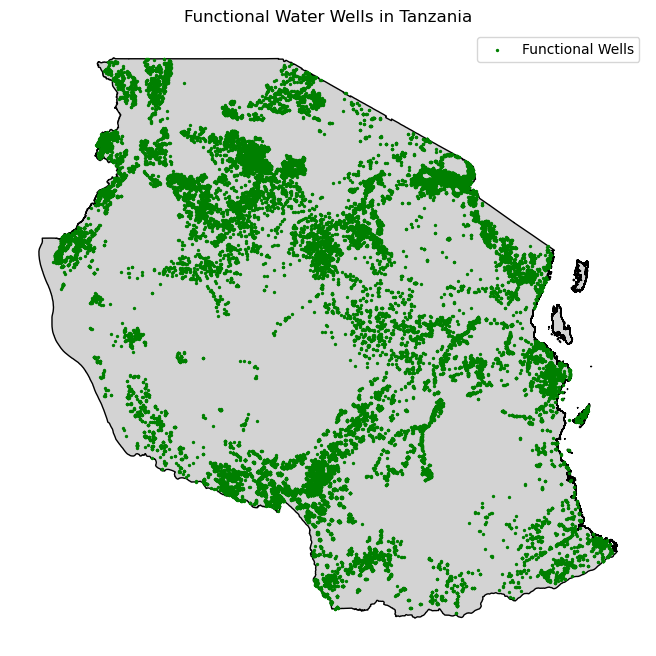

In [63]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Tanzania Shapefile
tanzania_boundary = gpd.read_file('/Users/jguzzo522/Desktop/twaterwell/TZA_adm/TZA_adm0.shp')

# Filter functional wells and select only latitude and longitude columns
functional_wells = merged_data.loc[merged_data['status_group_binary'] == 1, ['latitude', 'longitude']]

# Create a GeoDataFrame from latitude and longitude
functional_geo_df = gpd.GeoDataFrame(functional_wells, geometry=gpd.points_from_xy(functional_wells.longitude, functional_wells.latitude))

# Plot Tanzania boundary
fig, ax = plt.subplots(figsize=(10, 8))
tanzania_boundary.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)

# Plot functional wells
functional_geo_df.plot(ax=ax, color='green', markersize=2, label='Functional Wells')

# Set plot title
ax.set_title('Functional Water Wells in Tanzania')

# Remove axis
ax.set_axis_off()

# Add legend
plt.legend()

# Show plot
plt.show()


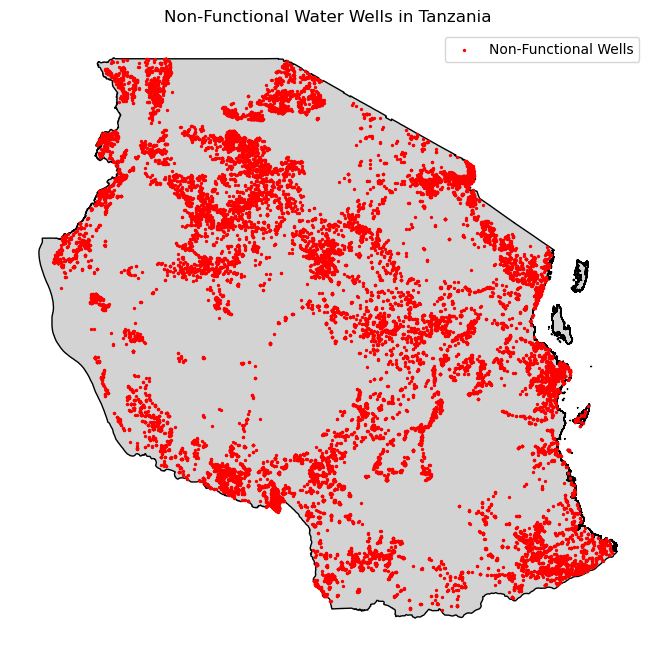

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Tanzania Shapefile
tanzania_boundary = gpd.read_file('/Users/jguzzo522/Desktop/twaterwell/TZA_adm/TZA_adm0.shp')

# Filter non-functional wells and select only latitude and longitude columns
non_functional_wells = merged_data.loc[merged_data['status_group_binary'] == 0, ['latitude', 'longitude']]

# Create a GeoDataFrame from latitude and longitude
non_functional_geo_df = gpd.GeoDataFrame(non_functional_wells, geometry=gpd.points_from_xy(non_functional_wells.longitude, non_functional_wells.latitude))

# Plot Tanzania boundary
fig, ax = plt.subplots(figsize=(10, 8))
tanzania_boundary.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)

# Plot non-functional wells
non_functional_geo_df.plot(ax=ax, color='red', markersize=2, label='Non-Functional Wells')

# Set plot title
ax.set_title('Non-Functional Water Wells in Tanzania')

# Remove axis
ax.set_axis_off()

# Add legend
plt.legend()

# Show plot
plt.show()


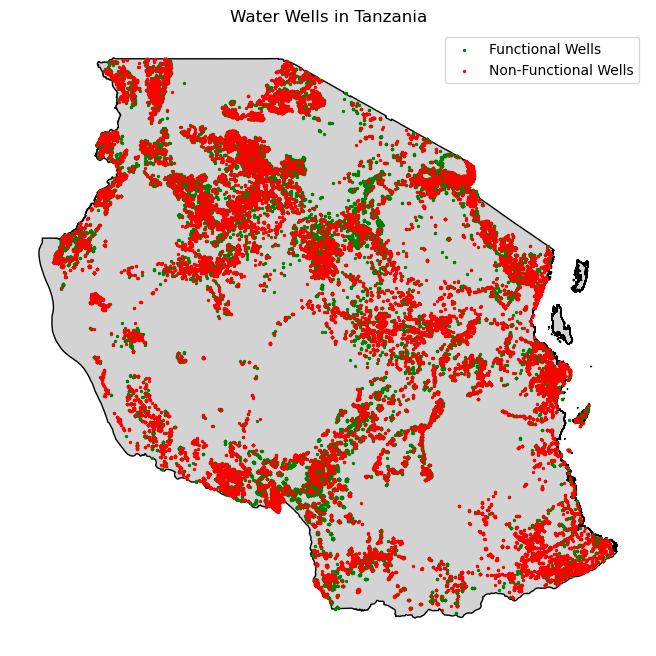

In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Tanzania Shapefile
tanzania_boundary = gpd.read_file('/Users/jguzzo522/Desktop/twaterwell/TZA_adm/TZA_adm0.shp')

# Filter functional and non-functional wells and select only latitude and longitude columns
functional_wells = merged_data.loc[merged_data['status_group_binary'] == 1, ['latitude', 'longitude']]
non_functional_wells = merged_data.loc[merged_data['status_group_binary'] == 0, ['latitude', 'longitude']]

# Create GeoDataFrames from latitude and longitude
functional_geo_df = gpd.GeoDataFrame(functional_wells, geometry=gpd.points_from_xy(functional_wells.longitude, functional_wells.latitude))
non_functional_geo_df = gpd.GeoDataFrame(non_functional_wells, geometry=gpd.points_from_xy(non_functional_wells.longitude, non_functional_wells.latitude))

# Plot Tanzania boundary
fig, ax = plt.subplots(figsize=(10, 8))
tanzania_boundary.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)

# Plot functional and non-functional wells
functional_geo_df.plot(ax=ax, color='green', markersize=2, label='Functional Wells')
non_functional_geo_df.plot(ax=ax, color='red', markersize=2, label='Non-Functional Wells')

# Set plot title
ax.set_title('Water Wells in Tanzania')

# Remove axis
ax.set_axis_off()

# Add legend
plt.legend()

# Show plot
plt.show()


## Assessment of Zero Values in GPS Height Data
Upon discovering a significant number of zero values in the GPS height data, further investigation was conducted to determine their validity.

A histogram was created to visualize the distribution of zero values in the GPS height data.
The visualization indicated that the number of zero values is relatively equal to other values in the distribution.

Based on the visual analysis, it was concluded that the zero values in the GPS height data appear to be valid and distributed similarly to other values. Therefore, the decision was made not to remove these values from the dataset.


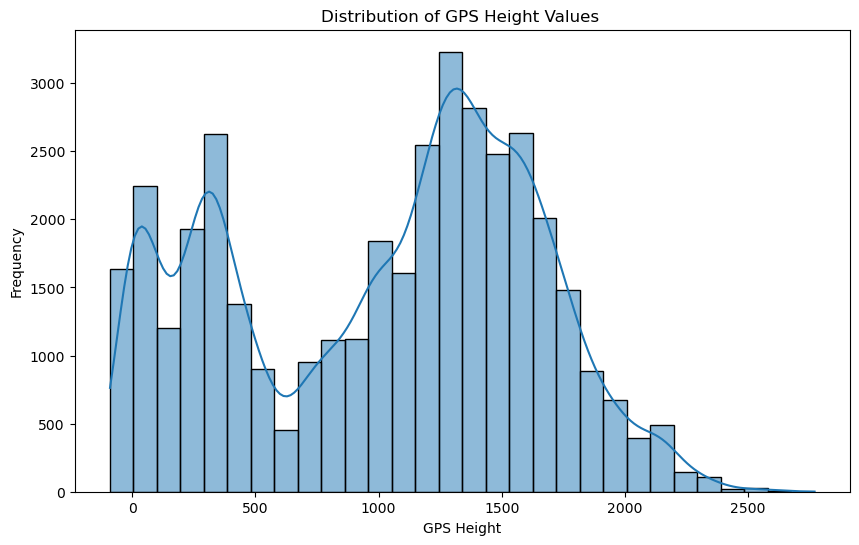

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out zero GPS height values
non_zero_gps_height = merged_data[merged_data['gps_height'] != 0]

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=non_zero_gps_height, x='gps_height', bins=30, kde=True)
plt.title('Distribution of GPS Height Values ')
plt.xlabel('GPS Height')
plt.ylabel('Frequency')
plt.show()


In [67]:
# Count the number of instances where  0 is present in the columns
basin_zero_count = (merged_data['basin'] == 0).sum()
print("Number of instances where basin is 0:", basin_zero_count)
region_zero_count = (merged_data['region'] == 0).sum()
print("Number of instances where region is 0:", region_zero_count)
region_code_zero_code = (merged_data['region_code'] == 0).sum()
print("Number of instances where region_code is 0:", region_code_zero_code)

Number of instances where basin is 0: 0
Number of instances where region is 0: 0
Number of instances where region_code is 0: 0


In [68]:
# Count the number of instances where  0 is present in the columns
extraction_type_zero_code = (merged_data['extraction_type'] == 0).sum()
print("Number of instances where extraction_type is 0:", extraction_type_zero_code)
management_group_zero_code = (merged_data['management_group'] == 0).sum()
print("Number of instances where mangement_group is 0:", management_group_zero_code)

Number of instances where extraction_type is 0: 0
Number of instances where mangement_group is 0: 0


## Reviewing Remaining Columns

In [69]:
# Check the data types of each column
print(merged_data.dtypes)


id                        int64
amount_tsh              float64
gps_height                int64
longitude               float64
latitude                float64
num_private               int64
basin                    object
region                   object
region_code               int64
district_code             int64
population              float64
extraction_type          object
management_group         object
payment                  object
water_quality            object
quantity                 object
source                   object
waterpoint_type          object
status_group_binary       int64
decade_construction      object
gps_height_categorym     object
dtype: object


### Searching for Categorical Data

In [70]:
# Select categorical columns
categorical_columns = merged_data.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)


['basin', 'region', 'extraction_type', 'management_group', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'decade_construction', 'gps_height_categorym']


## Ordinal Encoding of Decade of Construction

### Objective
The goal was to transform the `decade_construction` column, which categorizes the construction decade of water wells, from a categorical to an ordinal format. This conversion is crucial for machine learning models that require numerical input and can benefit from the inherent order within the data.

### Process
1. **Identification of Categorical Data**: Started by selecting columns with data type 'object' to identify all categorical columns within the dataset.
2. **Handling Missing Values**: Noted the presence of NaN values in `decade_construction` and filled these with 'Unknown' to maintain data integrity without discarding rows.
3. **Setting Categories**: Defined an explicit order for the decades (from '1960s' to '2010s', including 'Unknown') to reflect the chronological sequence, which is essential for ordinal encoding.
4. **Ordinal Encoding**: Utilized `OrdinalEncoder` from `sklearn.preprocessing` to convert the textual decade categories into ordered numerical values. This step transforms the inherently categorical information into a format that numerical algorithms can process, preserving the temporal order.

### Rationale
Ordinal encoding is preferred here because the construction decade of water wells is inherently ordered; newer wells might have different characteristics and failure rates compared to older ones. Representing decades as ordered numbers allows algorithms to understand and leverage this order, potentially improving predictive performance when forecasting well functionality or repair needs.

### Verification
Confirmed the successful encoding by displaying the unique categories and their corresponding encoded values. Also, printed a mapping of each decade to its ordinal value to ensure the encoding reflects the intended chronological order.

This approach empowers the dataset for more sophisticated analyses, where the construction decade can play a significant role in predictive modeling, offering insights into trends and influences of well construction over time.


In [71]:
print("NaNs in 'decade_construction' before Ordinal Encoding:", merged_data['decade_construction'].isnull().sum())


NaNs in 'decade_construction' before Ordinal Encoding: 0


In [72]:
merged_data['decade_construction'].fillna('Unknown', inplace=True)

# Verify categories are correctly set, including 'Unknown' if used
print("Unique categories in 'decade_construction':", merged_data['decade_construction'].unique())


Unique categories in 'decade_construction': ['1990s' '2010s' '2000s' '1980s' '1970s' '1960s']


In [73]:
from sklearn.preprocessing import OrdinalEncoder

# Define categories 
categories = [['1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'Unknown']]  

# Initialize the OrdinalEncoder with the defined categories
ordinal_encoder = OrdinalEncoder(categories=categories)

# Fit and transform 'decade_construction'
merged_data['decade_construction_ordinal'] = ordinal_encoder.fit_transform(merged_data[['decade_construction']])


In [74]:
# Display unique decades and their encoded values
unique_decades = merged_data['decade_construction'].unique()
unique_encoded_values = merged_data['decade_construction_ordinal'].unique()

print("Unique Decades:", unique_decades)
print("Unique Encoded Values:", unique_encoded_values)

# Optionally, to see a mapping of decade to its ordinal encoding
decade_encoding_mapping = merged_data[['decade_construction', 'decade_construction_ordinal']].drop_duplicates().sort_values(by='decade_construction_ordinal')
print(decade_encoding_mapping)


Unique Decades: ['1990s' '2010s' '2000s' '1980s' '1970s' '1960s']
Unique Encoded Values: [3. 5. 4. 2. 1. 0.]
    decade_construction  decade_construction_ordinal
100               1960s                          0.0
16                1970s                          1.0
3                 1980s                          2.0
0                 1990s                          3.0
2                 2000s                          4.0
1                 2010s                          5.0


In [75]:
# Exclude 'decade_construction' from the list of columns to dummy encode
categorical_columns.remove('decade_construction')  

# Now, dummy encode the remaining categorical columns
merged_data_encoded = pd.get_dummies(merged_data, columns=categorical_columns)

# Display the encoded dataset
print(merged_data_encoded.head())



      id  amount_tsh  gps_height  longitude   latitude  num_private  \
0  69572      6000.0        1390  34.938093  -9.856322            0   
1   8776         0.0        1399  34.698766  -2.147466            0   
2  34310        25.0         686  37.460664  -3.821329            0   
3  67743         0.0         263  38.486161 -11.155298            0   
4  19728         0.0           0  31.130847  -1.825359            0   

   region_code  district_code  population  status_group_binary  ...  \
0           11              5  109.000000                    1  ...   
1           20              2  280.000000                    1  ...   
2           21              4  250.000000                    1  ...   
3           90             63   58.000000                    0  ...   
4           18              1  281.087167                    1  ...   

  waterpoint_type_dam  waterpoint_type_hand pump  \
0                   0                          0   
1                   0                     

In [76]:
print(merged_data_encoded.columns)


Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'status_group_binary',
       ...
       'waterpoint_type_dam', 'waterpoint_type_hand pump',
       'waterpoint_type_improved spring', 'waterpoint_type_other',
       'gps_height_categorym_0 and below', 'gps_height_categorym_0-500',
       'gps_height_categorym_1000-1500', 'gps_height_categorym_1500-2000',
       'gps_height_categorym_2000+', 'gps_height_categorym_500-1000'],
      dtype='object', length=108)


Model 1 : Decision Tree Classifier

Before applying machine learning models, the dataset was divided into features (X) and the target variable (y). The features include all data points except for the status_group_binary, which serves as the target variable indicating the functionality of water wells.

The dataset was then split into training and testing sets, allocating 80% for training and 20% for testing. This split ensures a fair evaluation of the model's performance on unseen data, crucial for assessing its generalizability and effectiveness in real-world predictions.

Training Set: Used to train the model, allowing it to learn the relationship between features and the target variable.
Testing Set: Used to evaluate the model, providing an unbiased assessment of its performance on new, unseen data.

This preparation step is essential, laying the groundwork for applying and evaluating various machine learning models, including Random Forest and XGBoost.




In [77]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target variable (y)
X = merged_data_encoded.drop(columns=['status_group_binary'])
y = merged_data_encoded['status_group_binary']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)




Shape of X_train: (46070, 107)
Shape of X_test: (11518, 107)
Shape of y_train: (46070,)
Shape of y_test: (11518,)


We encoded categorical variables to numerical format using one-hot encoding and then split the data into training and testing sets. Next, we initialized and trained a decision tree classifier. Finally, we made predictions on the test set.

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the encoded data into training and testing sets
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize the decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the decision tree classifier on the training data
decision_tree.fit(X_train_encoded, y_train)

# Predict the target variable for the test set
y_pred = decision_tree.predict(X_test_encoded)

# Now, let's print the columns of your original dataset for clarity
print(merged_data_encoded.columns)

# And check the shapes of the train and test sets again to ensure everything is as expected
print("Shape of X_train_encoded:", X_train_encoded.shape)
print("Shape of X_test_encoded:", X_test_encoded.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'status_group_binary',
       ...
       'waterpoint_type_dam', 'waterpoint_type_hand pump',
       'waterpoint_type_improved spring', 'waterpoint_type_other',
       'gps_height_categorym_0 and below', 'gps_height_categorym_0-500',
       'gps_height_categorym_1000-1500', 'gps_height_categorym_1500-2000',
       'gps_height_categorym_2000+', 'gps_height_categorym_500-1000'],
      dtype='object', length=108)
Shape of X_train_encoded: (46070, 111)
Shape of X_test_encoded: (11518, 111)
Shape of y_train: (46070,)
Shape of y_test: (11518,)


## Model 1 Perfromance

Accuracy: The model achieved an accuracy of approximately 80.24%, indicating the proportion of correctly classified instances out of the total samples.

Confusion Matrix:

True Negative (TN): 3334 instances were correctly classified as negative (0).
False Negative (FN): 1092 instances were falsely classified as negative (0).
False Positive (FP): 1184 instances were falsely classified as positive (1).
True Positive (TP): 5908 instances were correctly classified as positive (1).
Classification Report:

Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. In this case, precision for class 0 is 0.74, and for class 1 is 0.84.
Recall: Recall is the ratio of correctly predicted positive observations to all actual positives. For class 0, recall is 0.75, and for class 1, it is 0.83.
F1-score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. The weighted average F1-score is approximately 0.80.
Support: The number of actual occurrences of each class in the specified dataset.
ROC AUC Score: The ROC AUC score measures the model's ability to discriminate between positive and negative classes. In this case, the ROC AUC score is approximately 0.793, indicating a strong discriminatory ability.

Overall Assessment: The model demonstrates decent performance in classifying the target variable based on the provided features, with a balanced performance across classes. However, there's room for improvement, particularly in reducing false negatives and false positives for better precision and recall.

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate ROC AUC score (if binary classification)
if len(np.unique(y_train)) == 2:
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC AUC Score:", roc_auc)


Accuracy: 0.8023962493488452
Confusion Matrix:
 [[3334 1092]
 [1184 5908]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.75      4426
           1       0.84      0.83      0.84      7092

    accuracy                           0.80     11518
   macro avg       0.79      0.79      0.79     11518
weighted avg       0.80      0.80      0.80     11518

ROC AUC Score: 0.793163710617336


The confusion matrix heatmap visually represents the classification results of the model. Along the x-axis are the predicted labels, while the y-axis shows the true labels. Each cell in the heatmap indicates the number of instances classified accordingly. The majority of instances lie along the diagonal, indicating correct predictions, while off-diagonal cells represent misclassifications. The color intensity reflects the frequency of predictions, with darker shades indicating higher counts. This visualization provides a clear overview of the model's performance in terms of true positive, false positive, true negative, and false negative classifications.


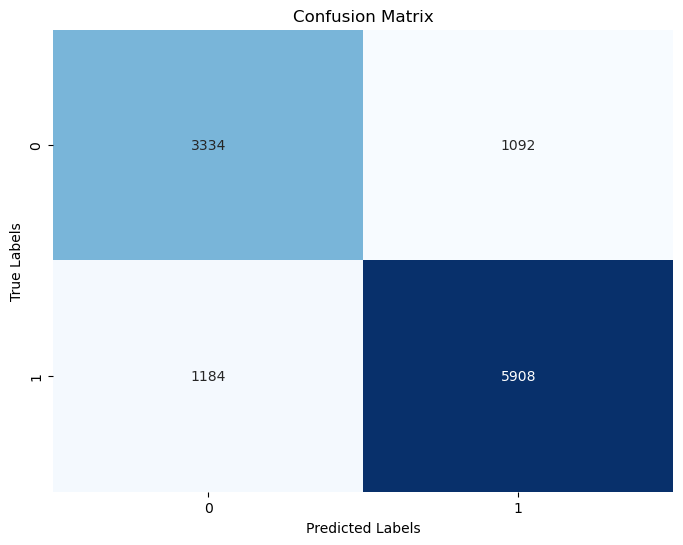

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Model 2 Random Forest

## Random Forest Classifier Model Summary

### Model Training and Testing
- The dataset was one-hot encoded to convert non-numeric columns into a format suitable for model training.
- The encoded data was split into training and testing sets with an 80-20 split, using a `random_state` of 42 for reproducibility.
- A Random Forest classifier was initialized with 100 estimators and trained on the encoded training data.
- The model was then used to make predictions on the test data.



In [81]:


# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_clf.fit(X_train_encoded, y_train)

# Make predictions on the test data
y_pred_rf = rf_clf.predict(X_test_encoded)




## Results of Model 2 Random Forest
### Accuracy: 
The model achieved an accuracy of 85.47%, indicating the proportion of correctly classified instances out of the total samples.

### Confusion Matrix:

True Negative (TN): 3387 instances were correctly classified as negative (0).
False Negative (FN): 635 instances were falsely classified as negative (0).
False Positive (FP): 1039 instances were falsely classified as positive (1).
True Positive (TP): 6457 instances were correctly classified as positive (1).


### Precision: 
Precision is the ratio of correctly predicted positive observations to the total predicted positives. In this case, precision for class 0 is 0.84, and for class 1 is 0.86.

### Recall: 
Recall is the ratio of correctly predicted positive observations to all actual positives. For class 0, recall is 0.77, and for class 1, it is 0.91.

### F1-score: 
The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. The weighted average F1-score is approximately 0.85.

ROC AUC Score: The ROC AUC score measures the model's ability to discriminate between positive and negative classes. In this case, the ROC AUC score is approximately 0.838, indicating a strong discriminatory ability.

Overall Assessment: The Random Forest classifier demonstrated a high level of accuracy and a strong ability to discriminate between classes, as evidenced by the ROC AUC score. The precision, recall, and F1-score across both classes indicate a balanced performance, though there's room for improvement in reducing false positives and false negatives.


In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", class_report)

# Calculate ROC AUC score (if binary classification)
if len(np.unique(y_train)) == 2:
    roc_auc = roc_auc_score(y_test, y_pred_rf)
    print("ROC AUC Score:", roc_auc)


Accuracy: 0.8546622677548186
Confusion Matrix:
 [[3387 1039]
 [ 635 6457]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      4426
           1       0.86      0.91      0.89      7092

    accuracy                           0.85     11518
   macro avg       0.85      0.84      0.84     11518
weighted avg       0.85      0.85      0.85     11518

ROC AUC Score: 0.8378566418657736


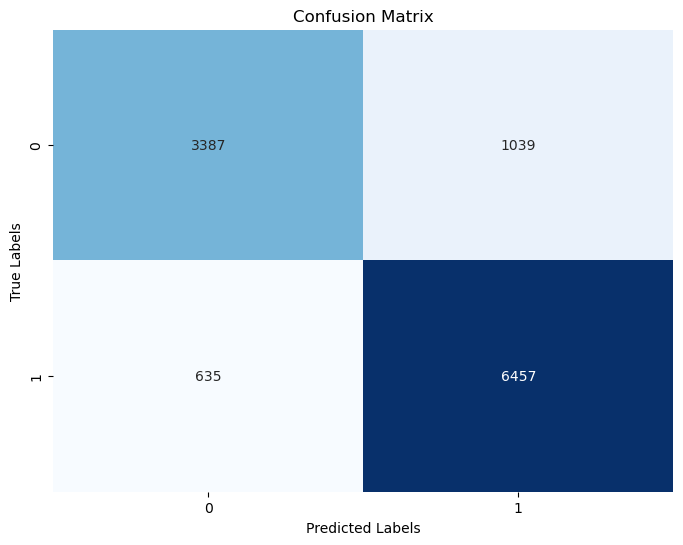

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Feature Importance Analysis with Random Forest Classifier

In this analysis, we aim to determine the importance of features in a predictive model, particularly using the Random Forest Classifier. Feature importance helps in understanding which features contribute the most to the predictive power of the model.

## Code Description

The provided Python code performs the following steps:

1. **Feature Importance Calculation**: The feature importances are extracted from the trained Random Forest Classifier (`rf_clf`). These importances reflect the contribution of each feature to the model's predictive performance.

2. **Visualization**: The feature importances are sorted in descending order and displayed as a bar plot to visualize the most important features. This helps in identifying the key variables driving the model's predictions.

## Important Values

The most important features (top N) are determined based on their importance scores. Here are some of the most important features:

1. **Latitude**: Importance Score - 0.112
2. **Longitude**: Importance Score - 0.110
3. **Quantity (Dry)**: Importance Score - 0.090
4. **GPS Height**: Importance Score - 0.056

## Output Visualization

The bar plot illustrates the top N important features and their respective importance scores. Each feature is represented on the y-axis, while the importance score is depicted on the x-axis. This visualization provides a clear understanding of the relative importance of different features in the model.



Feature Importances:
 latitude                                     0.112030
longitude                                    0.110151
quantity_dry                                 0.089544
id                                           0.080995
gps_height                                   0.055777
                                               ...   
extraction_type_cemo                         0.000159
extraction_type_walimi                       0.000126
water_quality_fluoride abandoned             0.000076
extraction_type_other - mkulima/shinyanga    0.000033
waterpoint_type_dam                          0.000023
Length: 111, dtype: float64


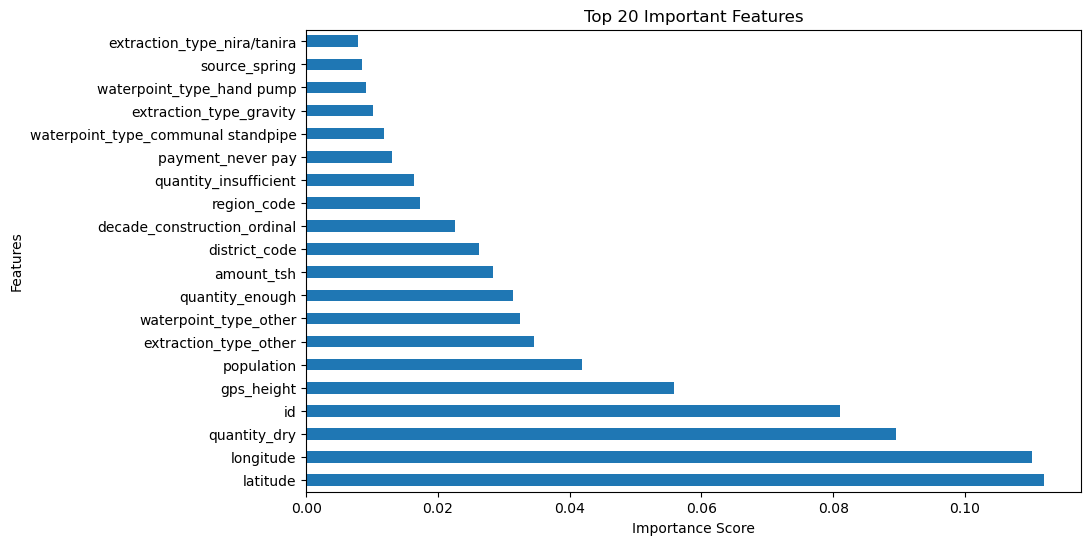

In [84]:
# Extract feature importances
importances = rf_clf.feature_importances_

# Convert feature importances into a pandas Series for easy manipulation and visualization
feature_importances = pd.Series(importances, index=X_train_encoded.columns)

# Sort the feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Display the sorted feature importances
print("Feature Importances:\n", sorted_feature_importances)

import matplotlib.pyplot as plt

# Select the top N features, for example top 20
top_n = 20
top_n_features = sorted_feature_importances[:top_n]

# Plotting
plt.figure(figsize=(10, 6))
top_n_features.plot(kind='barh')
plt.title(f'Top {top_n} Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()



# Model 3: XGBoost Classifier

## XGBoost Classifier Model Summary

### Model Training and Testing
- The dataset was one-hot encoded to convert non-numeric columns into a format suitable for model training.
- The encoded data was split into training and testing sets with an 80-20 split, using a `random_state` of 42 for reproducibility.
- An XGBoost classifier was initialized with default parameters and trained on the encoded training data.
- The model was then used to make predictions on the test data.

### Model 3 Performance
Accuracy: The model achieved an accuracy of 84.37% on the test set. It predicted 3124 true negatives, 1302 false positives, 498 false negatives, and 6594 true positives.

Precision and Recall: The model exhibited high precision and recall, particularly for class 1, indicating a strong ability to predict the target variable.

ROC AUC Score: The model achieved a ROC AUC score of 0.818, indicating a strong discriminatory ability between the positive and negative classes.

Interpretation
The XGBoost classifier demonstrated a high level of accuracy and a strong ability to discriminate between classes, as evidenced by the ROC AUC score. The precision, recall, and F1-score across both classes indicate a balanced performance, though there's room for improvement in reducing false positives and false negatives.

Feature Importance Analysis with XGBoost Classifier
In this analysis, we aimed to determine the importance of features in the predictive model using the XGBoost Classifier. Feature importance helps in understanding which features contribute the most to the predictive power of the model.

Accuracy: 0.844









In [85]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score



# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Train the classifier on the training data
xgb_clf.fit(X_train_encoded, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_clf.predict(X_test_encoded)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy_xgb)

# Calculate confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

# Calculate classification report
class_report_xgb = classification_report(y_test, y_pred_xgb)
print("Classification Report:\n", class_report_xgb)

# Calculate ROC AUC score (if binary classification)
if len(np.unique(y_train)) == 2:
    roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
    print("ROC AUC Score:", roc_auc_xgb)


Accuracy: 0.8437228685535684
Confusion Matrix:
 [[3124 1302]
 [ 498 6594]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78      4426
           1       0.84      0.93      0.88      7092

    accuracy                           0.84     11518
   macro avg       0.85      0.82      0.83     11518
weighted avg       0.85      0.84      0.84     11518

ROC AUC Score: 0.8178046124920959


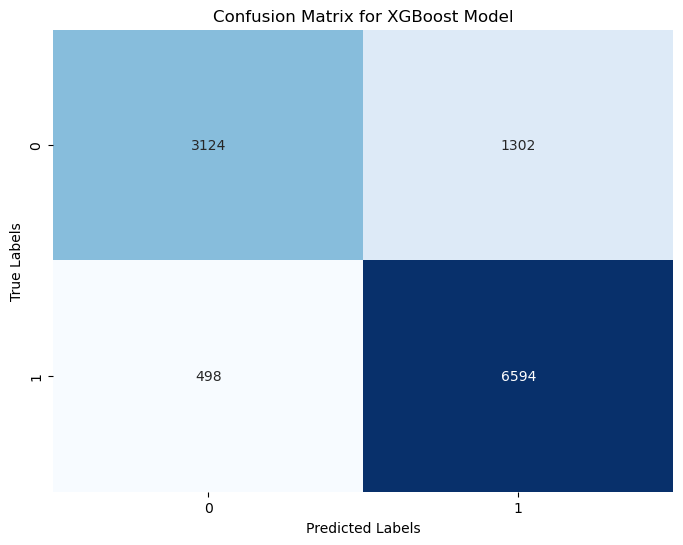

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()


# Important Values

The most important features (top N) are determined based on their importance scores. Here are some of the most important features:

1. **quantitiy_dry**: Importance Score - 0.220
2. **waterpoint_type_other**: Importance Score - 0.086
3. **extraction_type_other**: Importance Score - 0.432
4. **region_Mara**: Importance Score - 0.033

## Output Visualization

The bar plot illustrates the top N important features and their respective importance scores. Each feature is represented on the y-axis, while the importance score is depicted on the x-axis. This visualization provides a clear understanding of the relative importance of different features in the model.

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances
importances_xgb = xgb_clf.feature_importances_

# Convert feature importances into a pandas Series for easy manipulation and visualization
feature_importances_xgb = pd.Series(importances_xgb, index=X_train_encoded.columns)

# Sort the feature importances in descending order
sorted_feature_importances_xgb = feature_importances_xgb.sort_values(ascending=False)

# Display the sorted feature importances
print("Feature Importances:\n", sorted_feature_importances_xgb)


Feature Importances:
 quantity_dry                        0.220430
waterpoint_type_other               0.086147
extraction_type_other               0.043210
region_Mara                         0.032759
extraction_type_ksb                 0.024786
                                      ...   
extraction_type_walimi              0.000000
waterpoint_type_dam                 0.000000
gps_height_categorym_0 and below    0.000000
gps_height_categorym_2000+          0.000000
decade_construction_2010s           0.000000
Length: 111, dtype: float32


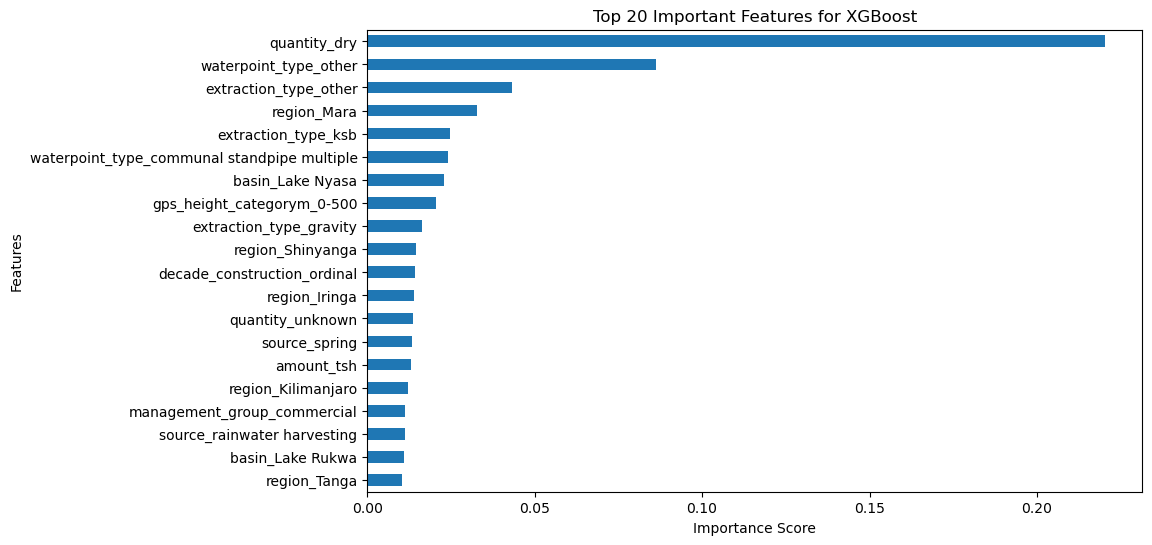

In [88]:
# Select the top N features, for example, top 20
top_n = 20
top_n_features_xgb = sorted_feature_importances_xgb[:top_n]

# Plotting
plt.figure(figsize=(10, 6))
top_n_features_xgb.plot(kind='barh')
plt.title(f'Top {top_n} Important Features for XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


## Model 4: Gradient Boosting Classifier

### Gradient Boosting Classifier Model Summary

#### Model Training and Testing
- The dataset was one-hot encoded to convert non-numeric columns into a format suitable for model training.
- The encoded data was split into training and testing sets with an 80-20 split, using a `random_state` of 42 for reproducibility.
- A Gradient Boosting classifier was initialized and trained on the encoded training data.
- The model was then used to make predictions on the test data.

#### Model 4 Performance

- **Accuracy**: The model achieved an accuracy of 79.81% on the test set.

### Classification Report

The classification report provides details about precision, recall, and F1-score for each class:

### ROC AUC Score

The ROC AUC score measures the model's ability to discriminate between positive and negative classes. In this case, the ROC AUC score is approximately 0.756.

### Feature Importances for Gradient Boosting Classifier

The feature importances for the Gradient Boosting Classifier are as follows:

- **quantity_dry**: 0.390077
- **waterpoint_type_other**: 0.124052
- **extraction_type_other**: 0.077586
- **decade_construction_ordinal**: 0.061608
- **amount_tsh**: 0.049068
  ...

These importances indicate the contribution of each feature to the predictive power of the model. Features with higher importances are more influential in making predictions, while features with lower importances have less impact.



In [89]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Initialize the Gradient Boosting classifier
gbm_clf = GradientBoostingClassifier(random_state=42)

# Train the classifier on the training data
gbm_clf.fit(X_train_encoded, y_train)

# Make predictions on the test data
y_pred_gbm = gbm_clf.predict(X_test_encoded)

# Evaluate the classifier
# Calculate accuracy
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print("Accuracy:", accuracy_gbm)

# Calculate confusion matrix
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
print("Confusion Matrix:\n", conf_matrix_gbm)

# Calculate classification report
class_report_gbm = classification_report(y_test, y_pred_gbm)
print("Classification Report:\n", class_report_gbm)

# Calculate ROC AUC score (if binary classification)
if len(np.unique(y_train)) == 2:
    roc_auc_gbm = roc_auc_score(y_test, y_pred_gbm)
    print("ROC AUC Score:", roc_auc_gbm)


Accuracy: 0.7981420385483591
Confusion Matrix:
 [[2529 1897]
 [ 428 6664]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.57      0.69      4426
           1       0.78      0.94      0.85      7092

    accuracy                           0.80     11518
   macro avg       0.82      0.76      0.77     11518
weighted avg       0.81      0.80      0.79     11518

ROC AUC Score: 0.7555233024156849


In [90]:
# Extract feature importances
feature_importances_gbm = gbm_clf.feature_importances_

# Convert feature importances into a pandas Series for easy manipulation and visualization
import pandas as pd
feature_importances_gbm_series = pd.Series(feature_importances_gbm, index=X_train_encoded.columns)

# Sort the feature importances in descending order
sorted_feature_importances_gbm = feature_importances_gbm_series.sort_values(ascending=False)

# Print the sorted feature importances
print("Feature Importances:\n", sorted_feature_importances_gbm)


Feature Importances:
 quantity_dry                     0.390077
waterpoint_type_other            0.124052
extraction_type_other            0.077586
decade_construction_ordinal      0.061608
amount_tsh                       0.049068
                                   ...   
water_quality_salty abandoned    0.000000
region_Mbeya                     0.000000
water_quality_salty              0.000000
region_Mtwara                    0.000000
decade_construction_2000s        0.000000
Length: 111, dtype: float64


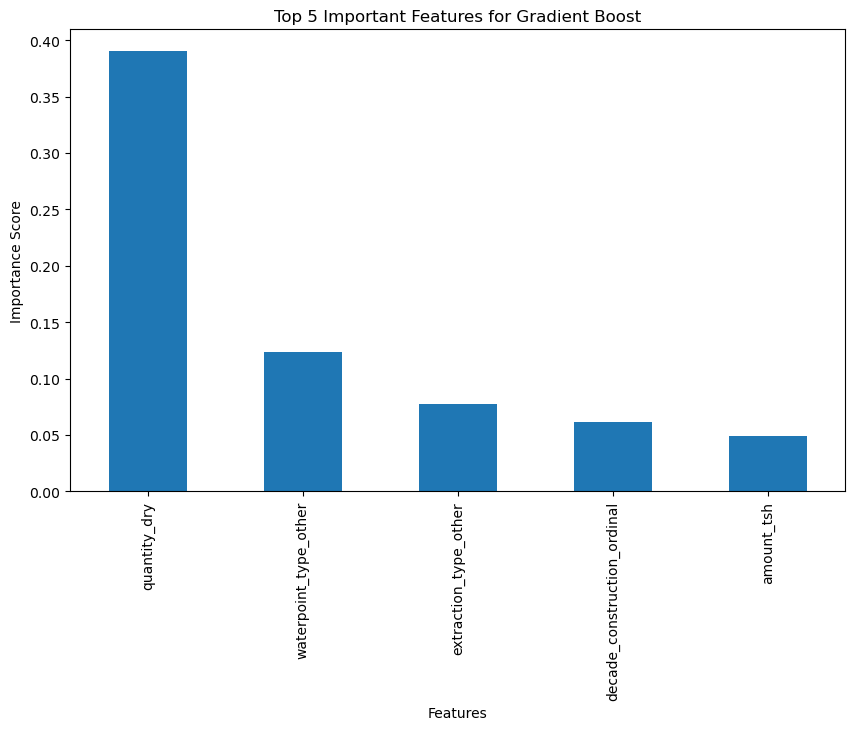

In [91]:
# Select the top N features
top_n = 5
top_n_features_gbm_clf = sorted_feature_importances_gbm[:top_n]

# Plotting
plt.figure(figsize=(10, 6))
# Use 'bar' instead of 'barh' for a vertical bar chart
top_n_features_gbm_clf.plot(kind='bar')
plt.title(f'Top {top_n} Important Features for Gradient Boost')
plt.ylabel('Importance Score')  # This is now the y-axis
plt.xlabel('Features')          # This is now the x-axis

# Here you might want to rotate the x-axis labels to make them readable
plt.xticks(rotation=90)

plt.show()



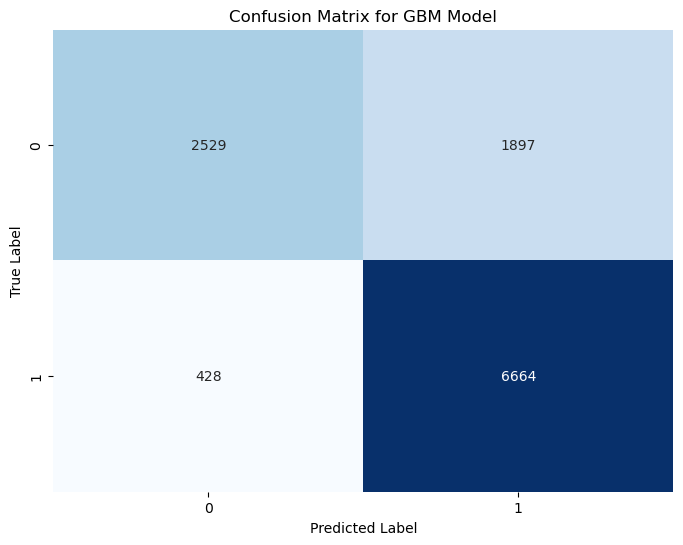

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for GBM Model')
plt.show()


## Model 5 Logistic Regression

### Logistic Regression Model Summary

#### Model Training and Testing
- The logistic regression model was trained using the encoded training data.
- Predictions were made on the test data using a threshold of 0.5.

#### Model Performance
- **Precision**: 0.729
- **Accuracy**: 0.722




In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns




Precision: 0.7293978748524204
Accuracy: 0.7216530647681889
Confusion Matrix:
 [[2134 2292]
 [ 914 6178]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.48      0.57      4426
           1       0.73      0.87      0.79      7092

    accuracy                           0.72     11518
   macro avg       0.71      0.68      0.68     11518
weighted avg       0.72      0.72      0.71     11518



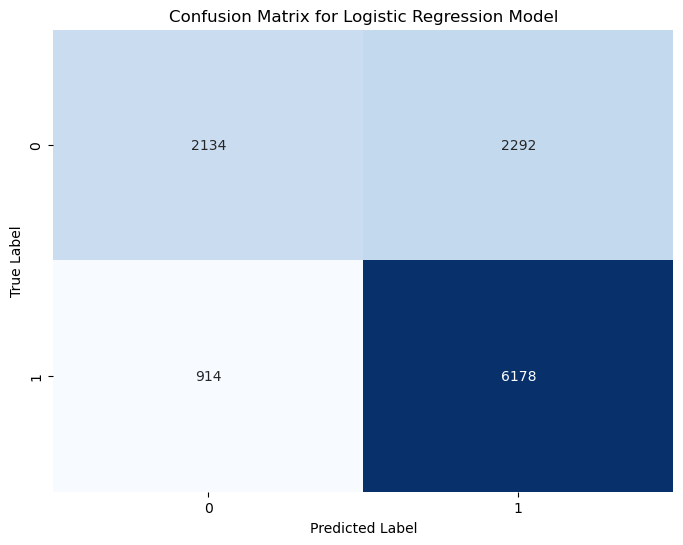

In [94]:
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_encoded, y_train)

# Predict probabilities for the test set
y_probs = log_reg.predict_proba(X_test_encoded)[:, 1]

# Apply the threshold (default: 0.5) to make predictions
y_pred = (y_probs > 0.5).astype(int)

# Evaluate the model
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print("Precision:", precision)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()


## Model Comparision 

Rationale for Model Selection
Based on the performance metrics and the project requirements, Model 4: Gradient Boosting Classifier, demonstrates the most promising results for predicting non-functioning water wells correctly. Here's the rationale:

False Negatives: Model 4 has the lowest number of false negatives (428) among all models. Since the goal is to minimize the misclassification of non-functioning wells as functioning, reducing false negatives is crucial.

Recall: Model 4 achieves the highest recall score (0.94) among all models. Recall measures the proportion of actual positives that were correctly identified by the model. In this case, it indicates that Model 4 effectively identifies a high percentage of non-functioning wells.

Accuracy: Although Model 4 has a slightly lower accuracy compared to Model 2, its emphasis on correctly identifying non-functioning wells makes it a more suitable choice for the project's objective.

Therefore, Model 4 is recommended for deployment in predicting the status of water wells, particularly focusing on minimizing false negatives to ensure effective maintenance and management of water resources.

| Model   | Precision | Recall | F1 Score | Support Class 0 | Support Class 1 | True Positive | True Negative | False Positive | False Negative | Accuracy |
|---------|-----------|--------|----------|------------------|------------------|----------------|----------------|------------------|------------------|-----------|
| Model 2 Random Forest | 0.85      | 0.91   | 0.89     | 3387             | 6457             | 6457           | 3387           | 1039             | 635              | 0.85      |
| Model 3: XGBoost Classifier | 0.84      | 0.93   | 0.88     | 3124             | 6594             | 6594           | 3124           | 1302             | 498              | 0.84      |
| Model 4: Gradient Boosting Classifier | 0.78      | 0.94   | 0.85     | 2529             | 6664             | 6664           | 2529           | 1897             | 428              | 0.80      |
| Model 5: Logistic Regression | 0.73      | 0.87   | 0.79     | 2134             | 6178             | 6178           | 2134           | 2292             | 914              | 0.72      |


# Visualizing Key Factors in Water Well Functionality

Baesed on the important features discovered in Model 4, visualizations were created. 

## Quantity

The first visualization highlights the critical role of water quantity in well functionality, demonstrating that wells labeled as 'dry' are functional only about 5% of the time. Similarly, wells with an 'unknown' water quantity are functional in only around 25% of cases, underscoring the urgency for the Tanzanian government to address water scarcity, particularly in areas with dry wells. This focused approach is crucial for mitigating the water crisis effectively. This graph provides a clear directive for policy and intervention strategies aimed at improving water access and sustainability.

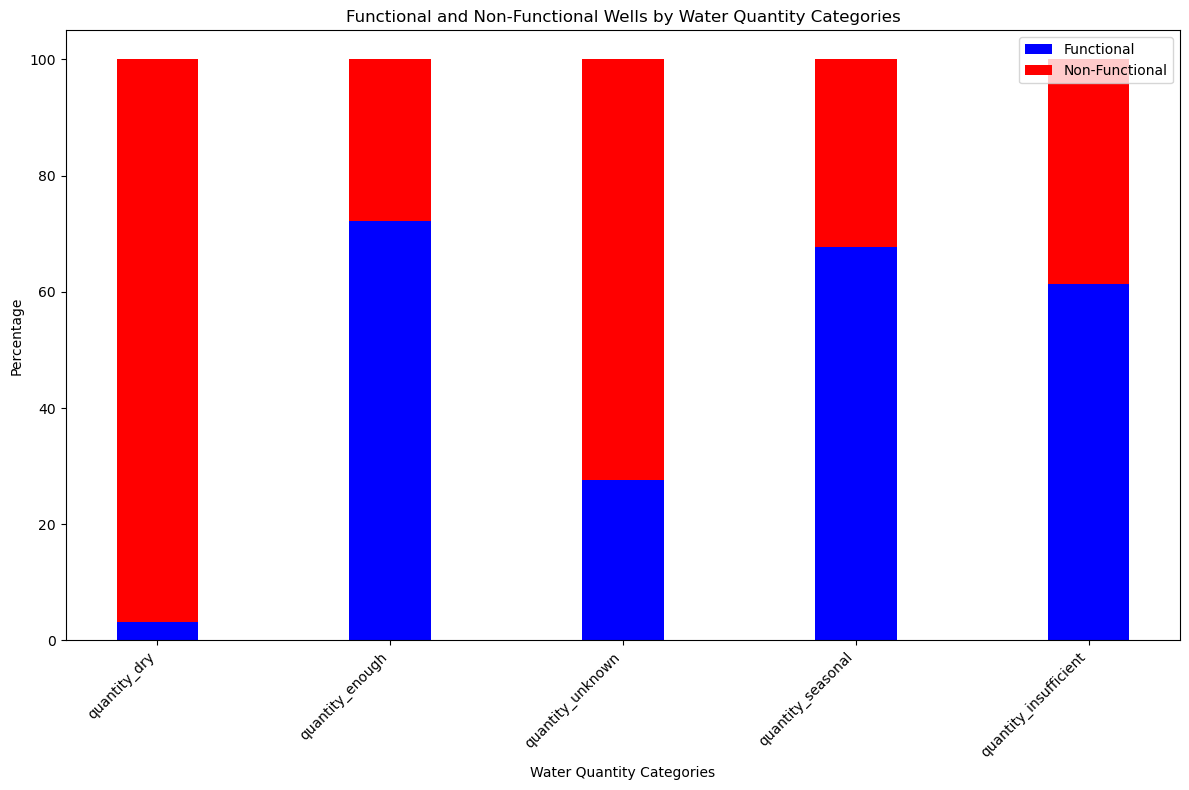

In [95]:
categories = ['quantity_dry', 'quantity_enough', 'quantity_unknown', 'quantity_seasonal', 'quantity_insufficient']
status_column = 'status_group_binary'

# Initialize a DataFrame to hold the percentage of functional/non-functional for each category
percentage_summary = pd.DataFrame(index=categories, columns=['Functional', 'Non-Functional'])

for category in categories:
    # Filter the DataFrame for the current category
    filtered_df = merged_data_encoded[merged_data_encoded[category] == 1]
    
    # Calculate the percentage of functional/non-functional wells in this category
    status_counts = filtered_df[status_column].value_counts(normalize=True) * 100
    percentage_summary.loc[category, 'Functional'] = status_counts.get(1, 0)  # Get 1 (functional) count, default to 0 if not present
    percentage_summary.loc[category, 'Non-Functional'] = status_counts.get(0, 0)  # Get 0 (non-functional) count

# Convert the summary DataFrame to numeric types for plotting
percentage_summary = percentage_summary.astype(float)

# Plot setup
plt.figure(figsize=(12, 8))
categories_index = np.arange(len(categories))
bar_width = 0.35

# Plotting
plt.bar(categories_index, percentage_summary['Functional'], bar_width, label='Functional', color='b')
plt.bar(categories_index, percentage_summary['Non-Functional'], bar_width, bottom=percentage_summary['Functional'], label='Non-Functional', color='r')

# Add labels, title, legend, and adjust layout
plt.xlabel('Water Quantity Categories')
plt.ylabel('Percentage')
plt.title('Functional and Non-Functional Wells by Water Quantity Categories')
plt.xticks(categories_index, categories, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [96]:
# Filter for columns starting with 'waterpoint'
quantity_feature_importances2 = sorted_feature_importances_gbm[sorted_feature_importances_gbm.index.str.startswith('waterpoint')]

# Print the filtered feature importances
print("Filtered Feature Importances for 'waterpoint':\n", quantity_feature_importances2)




Filtered Feature Importances for 'waterpoint':
 waterpoint_type_other                          0.124052
waterpoint_type_communal standpipe multiple    0.025007
waterpoint_type_communal standpipe             0.003872
waterpoint_type_improved spring                0.001044
waterpoint_type_cattle trough                  0.000021
waterpoint_type_dam                            0.000000
waterpoint_type_hand pump                      0.000000
dtype: float64


## Waterpoint
This visualization underscores the significant impact of water point types on well functionality. It highlights that water points categorized as 'other' have the lowest functionality rate, approximately 20%, indicating urgent attention is required. In contrast, communal standpipes perform notably better, though the variation within this category is significant. For example, communal standpipes (single) show satisfactory functionality, while communal standpipes (multiple) exhibit reduced effectiveness. This distinction suggests a need for the government to scrutinize the categorization of 'other' water points further and consider converting them to more reliable types, like the more effective communal standpipe model. Implementing targeted improvements based on these insights could significantly enhance water accessibility and reliability across communities.

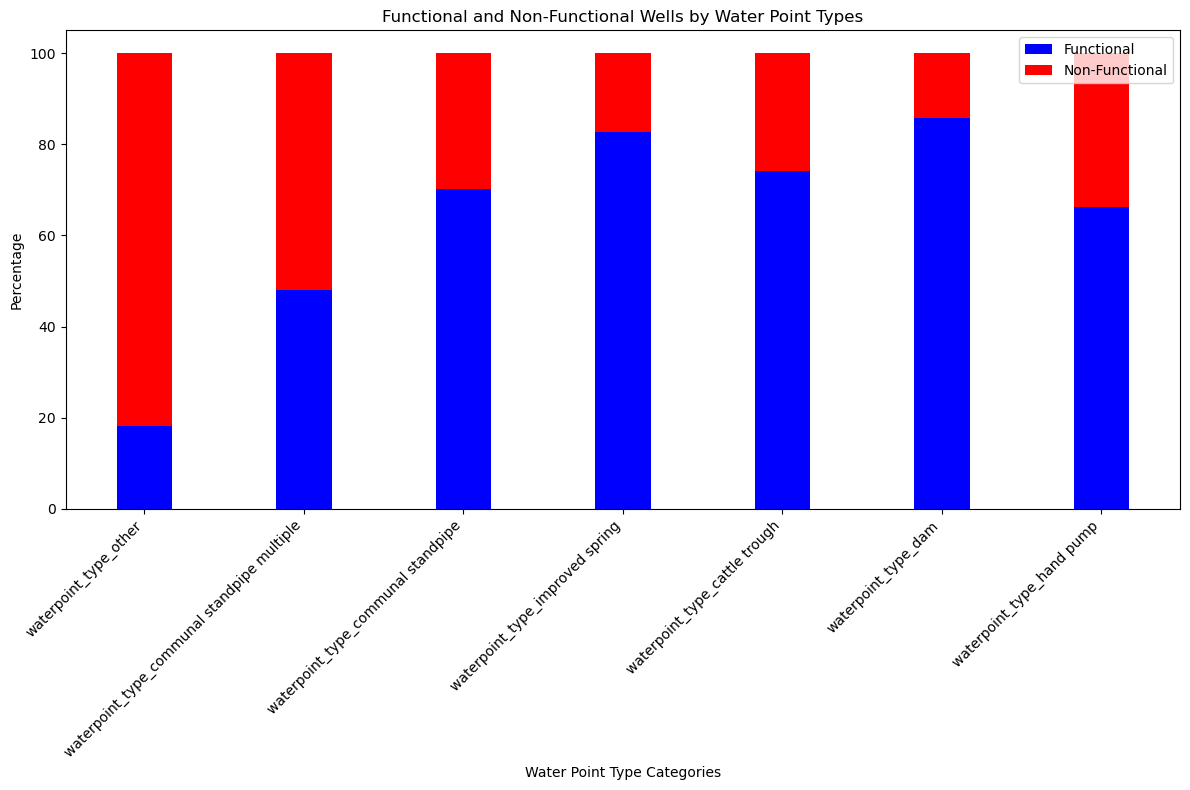

In [97]:
categories = ['waterpoint_type_other', 'waterpoint_type_communal standpipe multiple', 'waterpoint_type_communal standpipe', 'waterpoint_type_improved spring', 'waterpoint_type_cattle trough','waterpoint_type_dam' , 'waterpoint_type_hand pump' ]
status_column = 'status_group_binary'

# Initialize a DataFrame to hold the percentage of functional/non-functional for each category
percentage_summary = pd.DataFrame(index=categories, columns=['Functional', 'Non-Functional'])

for category in categories:
    # Filter the DataFrame for the current category
    filtered_df = merged_data_encoded[merged_data_encoded[category] == 1]
    
    # Calculate the percentage of functional/non-functional wells in this category
    status_counts = filtered_df[status_column].value_counts(normalize=True) * 100
    percentage_summary.loc[category, 'Functional'] = status_counts.get(1, 0)  # Get 1 (functional) count, default to 0 if not present
    percentage_summary.loc[category, 'Non-Functional'] = status_counts.get(0, 0)  # Get 0 (non-functional) count

# Convert the summary DataFrame to numeric types for plotting
percentage_summary = percentage_summary.astype(float)

# Plot setup
plt.figure(figsize=(12, 8))
categories_index = np.arange(len(categories))
bar_width = 0.35

# Plotting
plt.bar(categories_index, percentage_summary['Functional'], bar_width, label='Functional', color='b')
plt.bar(categories_index, percentage_summary['Non-Functional'], bar_width, bottom=percentage_summary['Functional'], label='Non-Functional', color='r')

# Add labels, title, legend, and adjust layout
plt.xlabel('Water Point Type Categories')
plt.ylabel('Percentage')
plt.title('Functional and Non-Functional Wells by Water Point Types')
plt.xticks(categories_index, categories, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


### Decade of Construction

This visualization illustrates the critical need for refurbishing older water wells in Tanzania. Data reveals a clear trend: the older the well, particularly those constructed in the 1960s, 1970s, and 1980s, the less likely it is to function adequately, with functionality rates falling below 50%. In contrast, wells built more recently demonstrate significantly better performance. Allocating resources towards the modernization of these older wells could markedly improve overall water availability, offering a tangible strategy for the Tanzanian government to boost water production and reliability.

In [98]:
# Counting the occurrences of each ordinal value in the actual data
ordinal_counts_actual = merged_data['decade_construction_ordinal'].value_counts().sort_index()

# Display the counts for each ordinal value
print(ordinal_counts_actual)


0.0      538
1.0     4406
2.0     5578
3.0    26575
4.0    15330
5.0     5161
Name: decade_construction_ordinal, dtype: int64


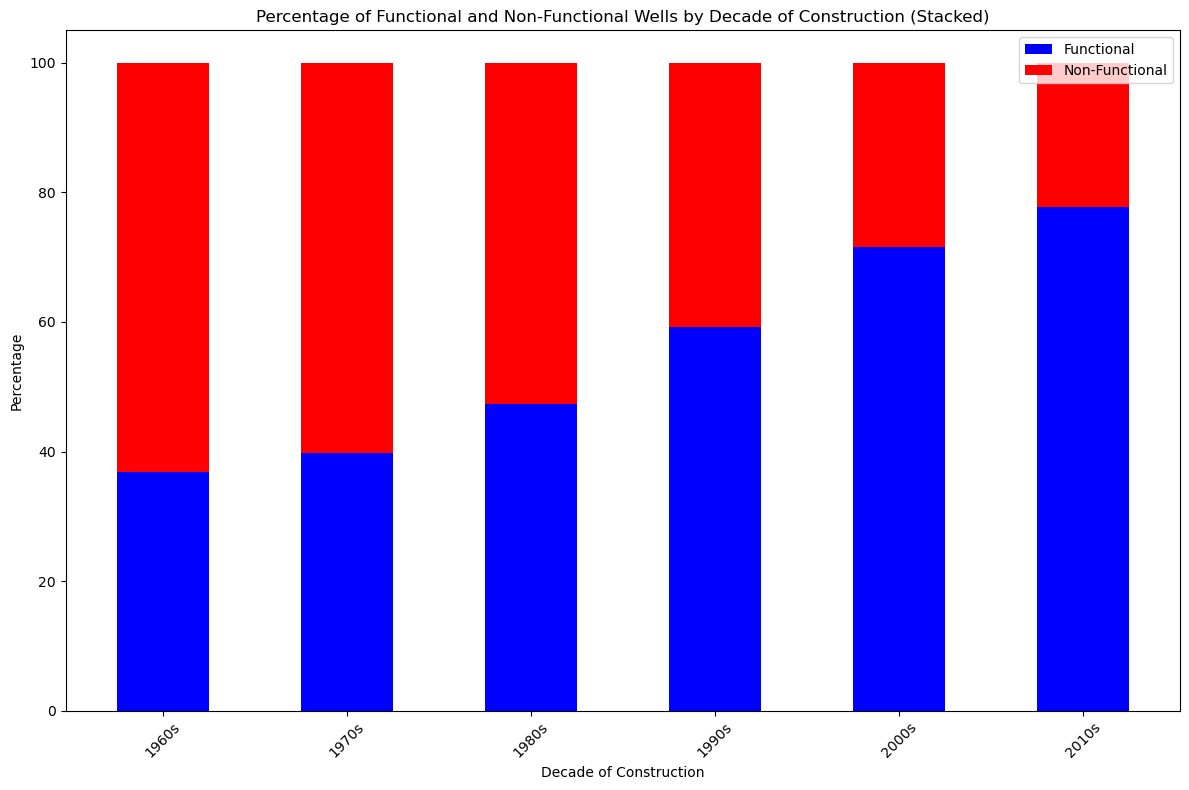

In [99]:
decade_labels = {
    0.0: '1960s',
    1.0: '1970s',
    2.0: '1980s',
    3.0: '1990s',
    4.0: '2000s',
    5.0: '2010s'
}

summary = merged_data.groupby('decade_construction_ordinal')['status_group_binary'].value_counts(normalize=True).unstack().fillna(0) * 100

import matplotlib.pyplot as plt
import numpy as np

# Plot setup
bar_width = 0.5  # Use a full bar width for stacking
categories_ordered = np.array(list(decade_labels.values()))  # Decade labels in order
index = np.arange(len(categories_ordered))

plt.figure(figsize=(12, 8))

plt.bar(index, summary[1], bar_width, color='b', label='Functional')
plt.bar(index, summary[0], bar_width, bottom=summary[1], color='r', label='Non-Functional')

# Add labels, title, legend, and adjust layout
plt.xlabel('Decade of Construction')
plt.ylabel('Percentage')
plt.title('Percentage of Functional and Non-Functional Wells by Decade of Construction (Stacked)')
plt.xticks(index, categories_ordered, rotation=45)  # Use the decade labels here
plt.legend()
plt.tight_layout()
plt.show()



# Recommendations 

The Tanzanian government should prioritize the following:

* Quantity Dry/Communal Standpipe Multiple
* Decade 1960-1990
* Water point type Other 

By prioritizing these wells, the Tanzanian government can allocate resources to fixing, or updating these wells. It is essential to have functional water-wells for the population of Tanzania. 

## Limitations

Although the dataset analyzed was comprehensive, it was not possible to examine every variable in detail. Notably, factors such as the well's funder or management entity, which could significantly impact water production, were not fully explored. For instance, cost-cutting measures by certain funders may compromise well quality, and some management companies may neglect necessary maintenance, impacting functionality. Without detailed analysis of these aspects, it's challenging to draw definitive conclusions about their impact on water well functionality.

In addition further examination of geographical features may prove important. This project did not directly distinguish between city water-wells and remote water-wells. 




# Addtional information

For a detailed analysis, see the [README](https://github.com/jguzzo522/twaterwell/blob/main/README.md).
For more insights, review the [Tanzanian Water Wells 2 PDF](https://github.com/jguzzo522/twaterwell/blob/main/Tanzanian%20Water%20Wells%202.pdf).
